# **LENDING CLUB CASE STUDY** 
## **Group Members :**
### **1. Karthick Chetti** - Group Fecilitator
### **2. Anirudh KVC** - Collaborator

## **Index of Notebook**
1. Objectives
2. Understanding Data
3. Data Cleaning
4. Selecting columns based on business objectives
5. Missing Value Imputation
6. Understanding variables and their datatypes


## **1. Objectives :**
1. Understanding the driving factors behind loan default thereby aiming to reduce credit loss 
2. Data Driven inferences to support the driving factors

In [349]:
# Load the libraries
import pandas as pd #To work with dataset
pd.set_option("display.max_columns", 100)
import numpy as np #Math library
import seaborn as sns #Graph library that use matplot in background
import matplotlib.pyplot as plt #to plot some parameters in seaborn
from matplotlib.ticker import PercentFormatter # for percentage

In [350]:
# Importing data from loan.csv
loan_df=pd.read_csv("loan.csv")

### **2. Understanding Data** 

In [351]:
loan_df.info(verbose=True,show_counts=True)
init_cols=len(loan_df.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Data columns (total 111 columns):
 #    Column                          Non-Null Count  Dtype  
---   ------                          --------------  -----  
 0    id                              39717 non-null  int64  
 1    member_id                       39717 non-null  int64  
 2    loan_amnt                       39717 non-null  int64  
 3    funded_amnt                     39717 non-null  int64  
 4    funded_amnt_inv                 39717 non-null  float64
 5    term                            39717 non-null  object 
 6    int_rate                        39717 non-null  object 
 7    installment                     39717 non-null  float64
 8    grade                           39717 non-null  object 
 9    sub_grade                       39717 non-null  object 
 10   emp_title                       37258 non-null  object 
 11   emp_length                      38642 non-null  object 
 12   home_ownership  

#### We can see that there are some null values in the columns and there are too many columns to analyze, hence measures have to be taken to clean data based on *business objectives* and based on *statistics*

### **3. Data Cleaning** : Based on Business Objective
### Filtering out data based on objective, since we are restricting our analysis to Charged off customers in the interest for the business objective

In [352]:
# Filtering data accorgingly
loan_df = loan_df[~(loan_df["loan_status"] == "Current")]

### **3. Data Cleaning** : A) Removing Columns with high percentage of null values

In [353]:
#Removing columns having 50% null values in them as such columns are not useful for analysis
lc_df=loan_df.dropna(axis=1,thresh=int(0.5*len(loan_df)))

In [354]:
#Printing number of columns removed
removed_columns=len(loan_df.columns)-len(lc_df.columns)
print(f"{removed_columns} columns were removed from original dataframe due to high amount of missing values in them")

57 columns were removed from original dataframe due to high amount of missing values in them


### **3. Data Cleaning** : B) Removing Columns with same values which are redundant for analysis

In [355]:
#### It is observed that some columns have only one value(mostly 0) throughout the rows, which are not useful for the analysis
dropped_col=[]
for col in lc_df.columns:
    if len(lc_df[col].unique())==1:
        dropped_col.append(col)
print(f"{len(dropped_col)} columns are dropped in the dataframe due to same values repeating throughout the column")
lc_df=lc_df.drop(dropped_col,axis=1)

8 columns are dropped in the dataframe due to same values repeating throughout the column


### **3. Data Cleaning** : C) Removing Columns with either 0s or missing values in them

In [356]:
for c in lc_df.columns:
    if len(lc_df[c].unique())==2:
        print(lc_df[c].unique())

[' 36 months' ' 60 months']
['Fully Paid' 'Charged Off']
[ 0. nan]
[ 0. nan]
[ 0. nan]


In [357]:
no_uniq_cols=["collections_12_mths_ex_med","chargeoff_within_12_mths","tax_liens"]
lc_df.drop(no_uniq_cols,axis=1,inplace=True)
print(f"{len(no_uniq_cols)} columns are dropped since they don't have meaningful unique values for analysis")

3 columns are dropped since they don't have meaningful unique values for analysis


In [358]:
exis_cols=len(lc_df.columns)
print(f"As a result of data cleaning, out of {init_cols} columns, {exis_cols} columns exist.\nHowever it is important to select the most relevant columns out of these {exis_cols} for analysis")

As a result of data cleaning, out of 111 columns, 43 columns exist.
However it is important to select the most relevant columns out of these 43 for analysis


### **4. Selecting most relevant features as per business objective** 
### Additional features/columns will be added to the analysis in the future if it's found relevant

In [359]:
# Key features
# Here id is conidered for aggregation purpose
req_features=["id","loan_amnt","term","int_rate","grade","home_ownership","emp_length","annual_inc","verification_status","purpose","dti","loan_status"]
lc_df = lc_df[req_features]

In [360]:
# Having a look at the data
lc_df.head()

,id,loan_amnt,term,int_rate,grade,home_ownership,emp_length,annual_inc,verification_status,purpose,dti,loan_status
0,1077501,5000,36 months,10.65%,B,RENT,10+ years,24000.0,Verified,credit_card,27.65,Fully Paid
1,1077430,2500,60 months,15.27%,C,RENT,< 1 year,30000.0,Source Verified,car,1.00,Charged Off
2,1077175,2400,36 months,15.96%,C,RENT,10+ years,12252.0,Not Verified,small_business,8.72,Fully Paid
3,1076863,10000,36 months,13.49%,C,RENT,10+ years,49200.0,Source Verified,other,20.00,Fully Paid
5,1075269,5000,36 months,7.90%,A,RENT,3 years,36000.0,Source Verified,wedding,11.20,Fully Paid


In [361]:
# Understanding the data and data types
lc_df.info(verbose=True,show_counts=True)
lc_df.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38577 entries, 0 to 39716
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   38577 non-null  int64  
 1   loan_amnt            38577 non-null  int64  
 2   term                 38577 non-null  object 
 3   int_rate             38577 non-null  object 
 4   grade                38577 non-null  object 
 5   home_ownership       38577 non-null  object 
 6   emp_length           37544 non-null  object 
 7   annual_inc           38577 non-null  float64
 8   verification_status  38577 non-null  object 
 9   purpose              38577 non-null  object 
 10  dti                  38577 non-null  float64
 11  loan_status          38577 non-null  object 
dtypes: float64(2), int64(2), object(8)
memory usage: 3.8+ MB


,id,loan_amnt,annual_inc,dti
count,3.857700e+04,38577.000000,3.857700e+04,38577.000000
mean,6.763787e+05,11047.025430,6.877797e+04,13.272727
std,2.092639e+05,7348.441646,6.421868e+04,6.673044
min,5.473400e+04,500.000000,4.000000e+03,0.000000
25%,5.120330e+05,5300.000000,4.000000e+04,8.130000
50%,6.564230e+05,9600.000000,5.886800e+04,13.370000
75%,8.291460e+05,15000.000000,8.200000e+04,18.560000
max,1.077501e+06,35000.000000,6.000000e+06,29.990000


### **5. Missing value imputation**

### There are some columns which have missing values,Therefore understanding the number of missing values in these columns

In [362]:
empty_cols=lc_df.columns[lc_df.isna().any()].tolist()
empty_vals=[round(lc_df[col].isna().sum()*100/len(lc_df[col]),2) for col in empty_cols]
empty_per_dict=dict(zip(empty_cols,empty_vals))
print("The missing values percentage in columns is :\n",empty_per_dict)

The missing values percentage in columns is :
 {'emp_length': 2.68}


#### It is observed that in selected columns for analysis, 'emp_length' column has some missing data

In [363]:
# As the number of missing data is less, missing value imputation can be done
# Checking the values in emp_length column
lc_df["emp_length"].value_counts()

10+ years    8488
< 1 year     4508
2 years      4291
3 years      4012
4 years      3342
5 years      3194
1 year       3169
6 years      2168
7 years      1711
8 years      1435
9 years      1226
Name: emp_length, dtype: int64

In [364]:
# Data imputation since total missing value percentage is less than 5%
#  As the most recurring value is 10+years, adding 10+ years whereever the data is missing
lc_df["emp_length"] = lc_df["emp_length"].fillna(lc_df["emp_length"].value_counts().index[0])

### **6. Understanding variables and their datatypes**

In [365]:
#Understanding the datatypes in the dataframe
lc_df.info(verbose=True,show_counts=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38577 entries, 0 to 39716
Data columns (total 12 columns):
 #   Column               Dtype  
---  ------               -----  
 0   id                   int64  
 1   loan_amnt            int64  
 2   term                 object 
 3   int_rate             object 
 4   grade                object 
 5   home_ownership       object 
 6   emp_length           object 
 7   annual_inc           float64
 8   verification_status  object 
 9   purpose              object 
 10  dti                  float64
 11  loan_status          object 
dtypes: float64(2), int64(2), object(8)
memory usage: 3.8+ MB


In [366]:
# Removing % and converting to float
lc_df["int_rate"]=lc_df["int_rate"].str.replace("%","").astype(float)
req_features=["id","loan_amnt","term","int_rate","grade","home_ownership","emp_length","annual_inc","verification_status","purpose","dti","loan_status"]

### **Understanding type of variable for analysis**
1. **Numeric Data** : <br>
loan_amt,int_rate,annual_inc,dti

2. **Ordered Categorical Data** : <br>
term,grade,emp_length

3. **Unordered Categorical Data** : <br>
home_ownership,purpose,verification_status,loan_status

*id column can be used as a unique row identifier*

In [367]:
#Declaring type of variables
numeric_data=["loan_amnt","int_rate","annual_inc","dti"]
ordered_cat_data=["term","grade","emp_length"]
unordered_cat_data=["home_ownership","purpose","verification_status","loan_status"]

### **7. Data Distribution and Outlier Correction for Numeric Data**

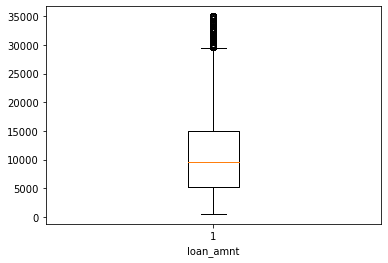

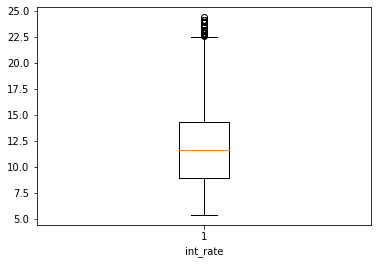

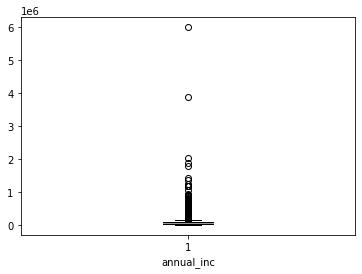

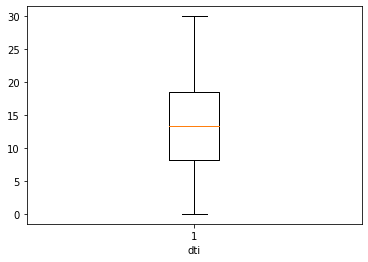

In [368]:
#Checking the distributions for numeric data
#Function to plot box plots taking dataframe and columns as input
def box_plot_col(df,cols):
    for col in cols:
        plt.boxplot(df[col])
        plt.xlabel(col)
        plt.show()
box_plot_col(lc_df,numeric_data)

### Outliers are detected in the box plot for some variables, it is important to remove outliers in the data based on IQR 

In [369]:
#Remove outliers based on IQR (Taking Threshold as 20% because taking 25% standard value is removing many points which might be useful)
def remove_outliers(df,cols,thresh):
    for col in cols:
        ser=df[col]
        Q1 = ser.quantile(thresh)
        Q3 = ser.quantile(1-thresh)
        IQR = Q3 - Q1
        df = df[~(ser > (Q3 + 1.5 * IQR))]
    return df
lc_df=remove_outliers(lc_df,numeric_data,0.20)
removed_data_points=len(loan_df)-len(lc_df)
print(f"{removed_data_points} data points were removed because they were outliers in the numeric data columns")

1650 data points were removed because they were outliers in the numeric data columns


### **1. Univariate Analysis**

In [370]:
#Looking at dataframe after data cleaning
lc_df.head()

,id,loan_amnt,term,int_rate,grade,home_ownership,emp_length,annual_inc,verification_status,purpose,dti,loan_status
0,1077501,5000,36 months,10.65,B,RENT,10+ years,24000.0,Verified,credit_card,27.65,Fully Paid
1,1077430,2500,60 months,15.27,C,RENT,< 1 year,30000.0,Source Verified,car,1.00,Charged Off
2,1077175,2400,36 months,15.96,C,RENT,10+ years,12252.0,Not Verified,small_business,8.72,Fully Paid
3,1076863,10000,36 months,13.49,C,RENT,10+ years,49200.0,Source Verified,other,20.00,Fully Paid
5,1075269,5000,36 months,7.90,A,RENT,3 years,36000.0,Source Verified,wedding,11.20,Fully Paid


In [371]:
#Statistical Insights
lc_df[numeric_data].describe()

,loan_amnt,int_rate,annual_inc,dti
count,36927.000000,36927.000000,36927.000000,36927.000000
mean,10476.209142,11.846419,62267.328650,13.380777
std,6597.036775,3.643279,30206.253054,6.660514
min,500.000000,5.420000,4000.000000,0.000000
25%,5000.000000,8.900000,40000.000000,8.270000
50%,9200.000000,11.710000,56100.000000,13.500000
75%,14837.500000,14.270000,78996.000000,18.650000
max,32500.000000,24.400000,169000.000000,29.990000


In [372]:
#Inferences from statistical insights

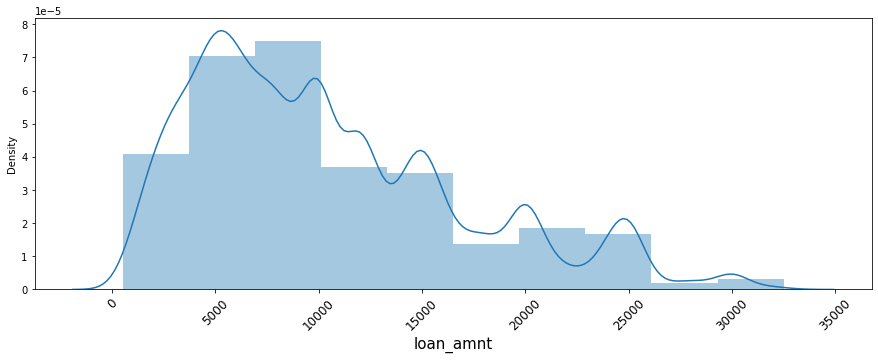

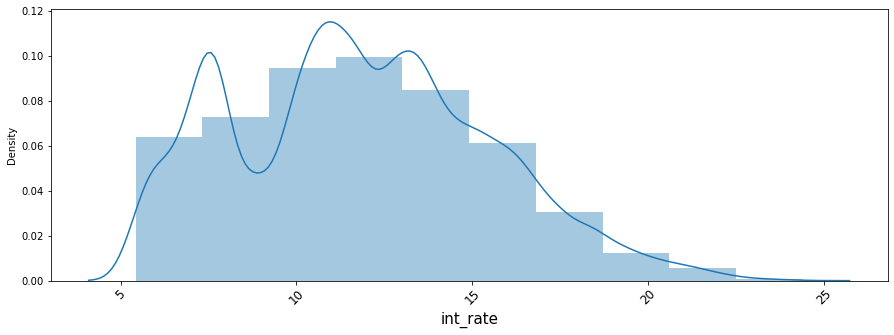

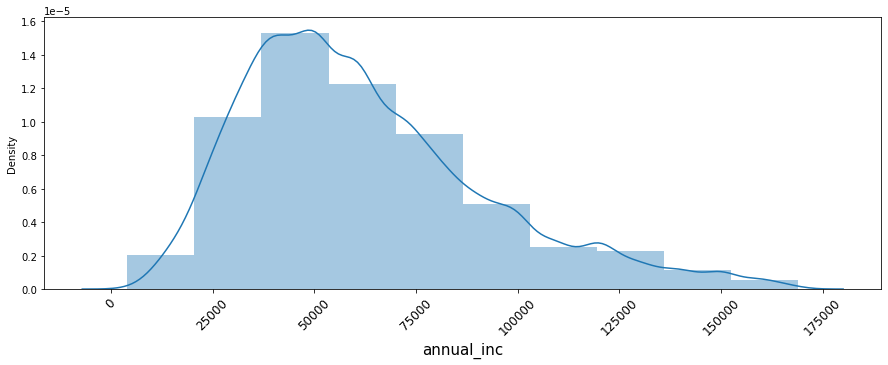

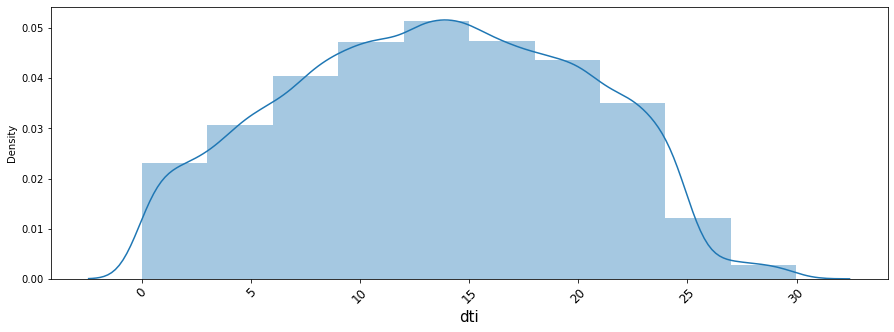

In [373]:
#Plotting distribution plots for numeric variables 
import warnings
warnings.filterwarnings("ignore")
for col in numeric_data:
    plt.figure(figsize=(15,5))
    sns.distplot(lc_df[col],bins=10)
    plt.xticks(fontsize=12,rotation = 45)
    plt.xlabel(col,fontsize=15)
    plt.show()

## Inferences :
### 1. Majority of charged off loan amounts are taken between 4000 to 11000
### 2. Loans taken for term of 36 months have more charged off customers compared to loan term of 60 months
### 3. More charged off people take loans in 11-15% interest rate
### 4. Loans offered in B,C,D grades have high charged off customers with B5 sub grade having the highest
### 5. People with rented or mortgaged homes are mostly charging off compared to other categories
### 6. Employees with experience more than 10 years majorly charge off
### 7. Employees having annual income between 40000 to 55000 majorly charge off
### 8. People taking loans for debt consolidation are significantly charge off more
### 9. Customers whose data is not verified tend to charge off more
### 10. Customers whose dti is between 12-21 charge off more compared to other dti ratios



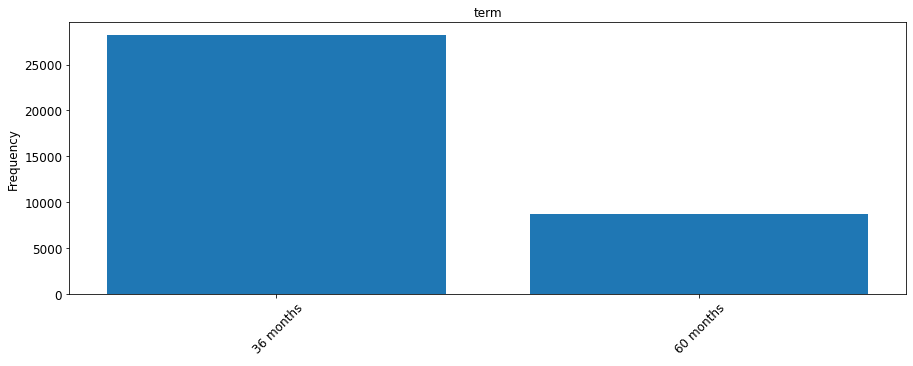

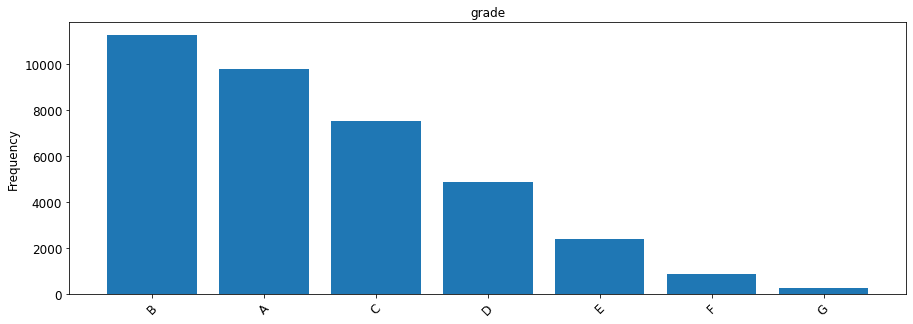

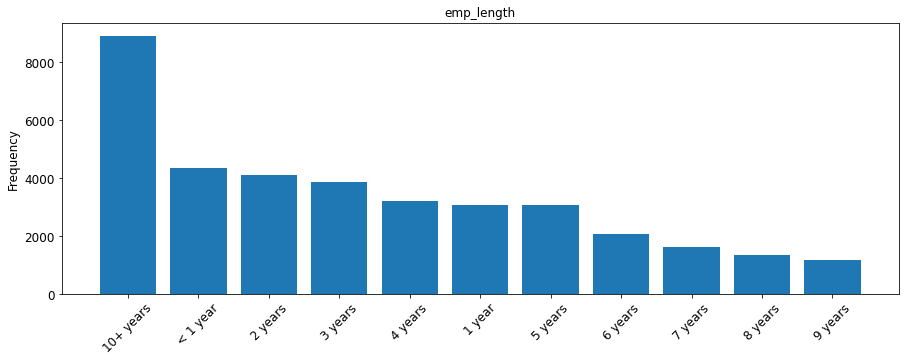

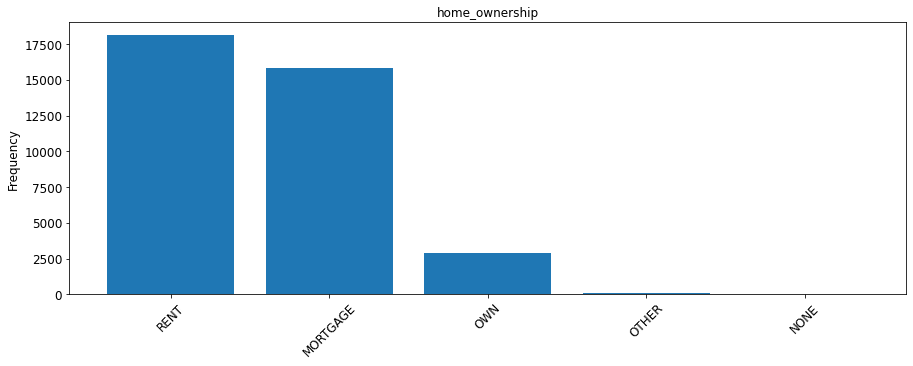

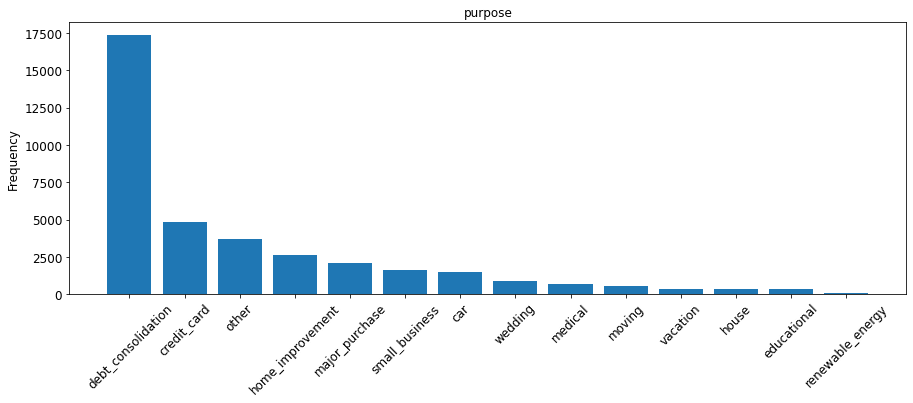

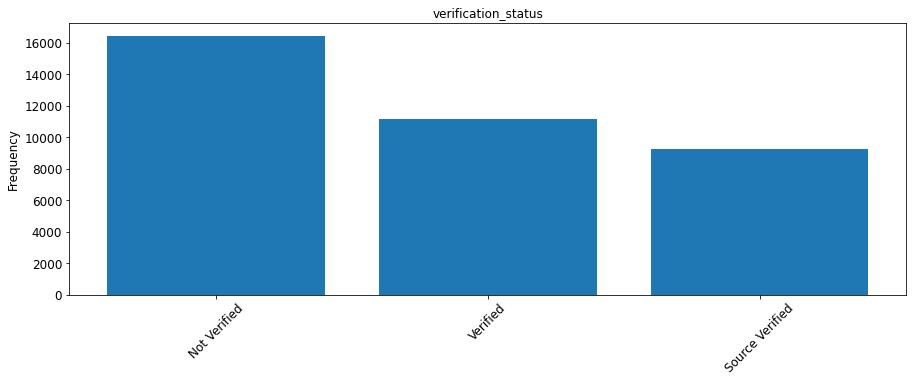

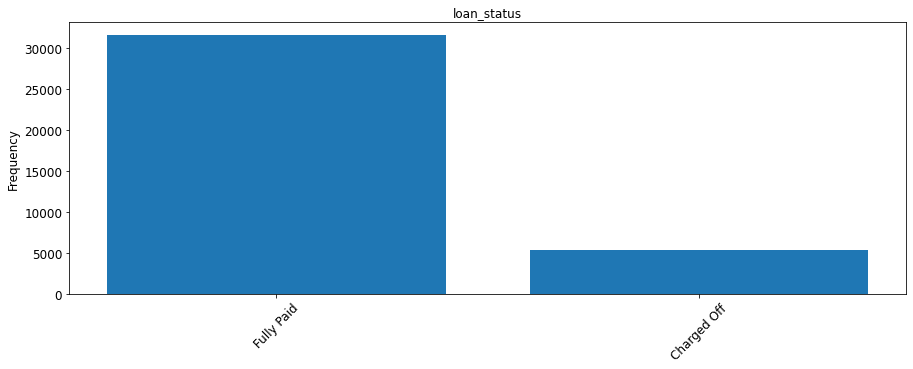

In [374]:
#Plotting bar for ordered categorical variables & unordered categorical variables
cat_data=ordered_cat_data+unordered_cat_data
for col in cat_data :
    plt.figure(figsize=(15,5))
    plt.bar(lc_df[col].value_counts().index,lc_df[col].value_counts().values)
    plt.xticks(fontsize=12,rotation = 45)
    plt.title(col)
    plt.ylabel("Frequency",fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()

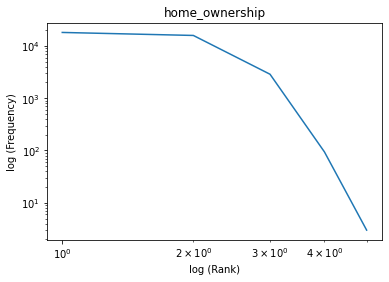

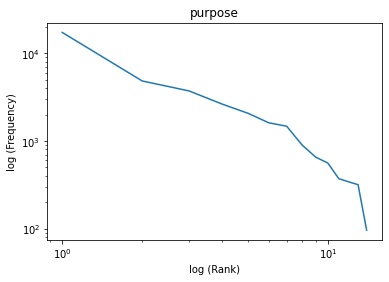

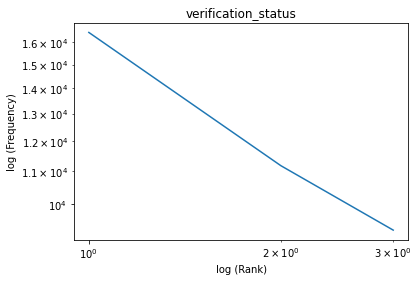

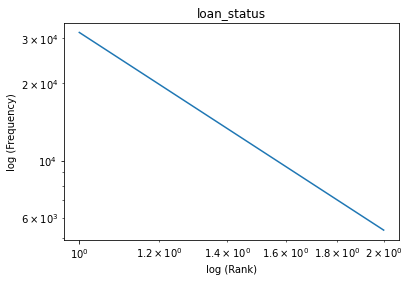

In [375]:
#Unordered categorical variables
for i in unordered_cat_data:
    if i!="zip_code":
        x_data = np.arange(1,len(lc_df[i].value_counts())+1)
        y_data = lc_df[i].value_counts().values
        plt.loglog(x_data,y_data)
        plt.xlabel("log (Rank)")
        plt.ylabel("log (Frequency)")
        plt.title(i)
        plt.show()


In [376]:
#Inferences
# From the rank vs frequency plots it can be inferred that verification_status,loan_status follows power law distribution,
# purpose follows near power law distribution

### **Segmented Univariate Analysis**

In [377]:
#Statistical Insights
fp=lc_df[lc_df.loan_status=="Fully Paid"]
co=lc_df[lc_df.loan_status=="Charged Off"]
print("Fully Paid\n",fp[numeric_data].describe())
print("Charged Off\n",co[numeric_data].describe())

Fully Paid
           loan_amnt      int_rate     annual_inc           dti
count  31563.000000  31563.000000   31563.000000  31563.000000
mean   10334.622026     11.533319   63155.311162     13.263868
std     6495.174602      3.558216   30392.454285      6.665610
min      500.000000      5.420000    4000.000000      0.000000
25%     5000.000000      8.490000   40000.000000      8.120000
50%     9000.000000     11.480000   57700.000000     13.340000
75%    14400.000000     13.980000   80000.000000     18.520000
max    32500.000000     24.110000  169000.000000     29.990000
Charged Off
           loan_amnt     int_rate     annual_inc          dti
count   5364.000000  5364.000000    5364.000000  5364.000000
mean   11309.340045    13.688768   57042.236924    14.068697
std     7110.922433     3.592941   28534.807584     6.589181
min      900.000000     5.420000    4080.000000     0.000000
25%     5400.000000    11.140000   36000.000000     9.137500
50%    10000.000000    13.490000   51202.0

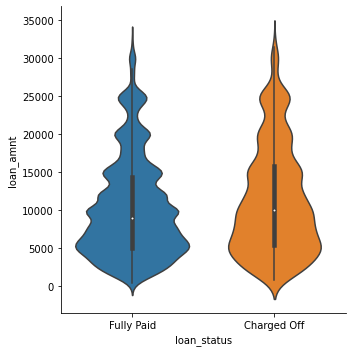

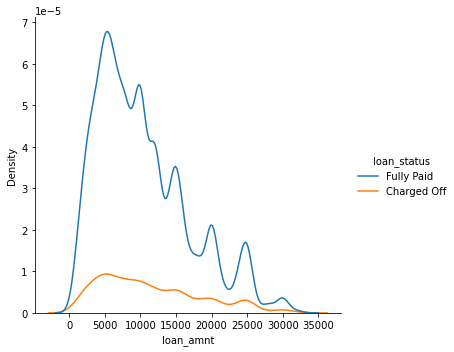

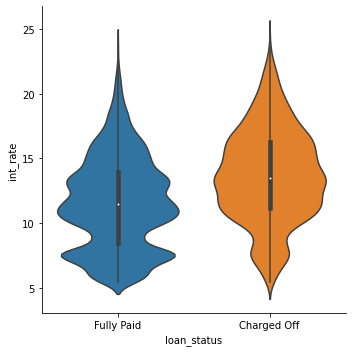

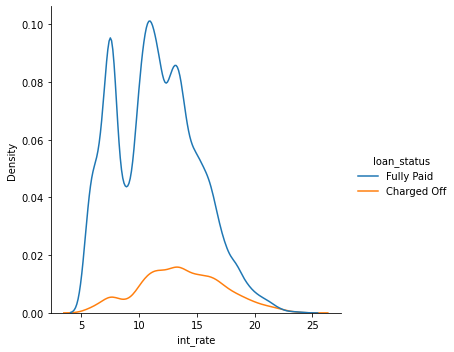

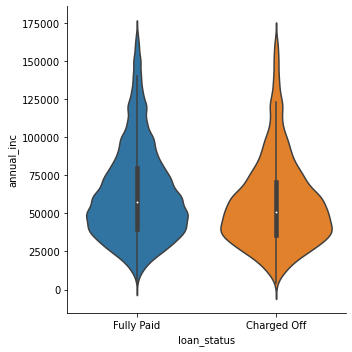

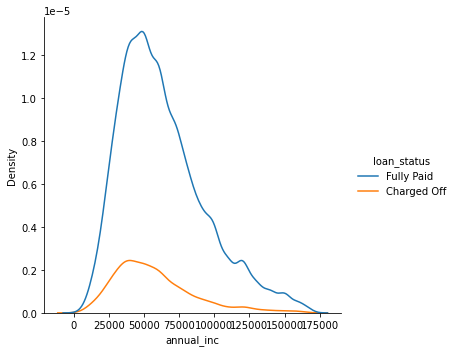

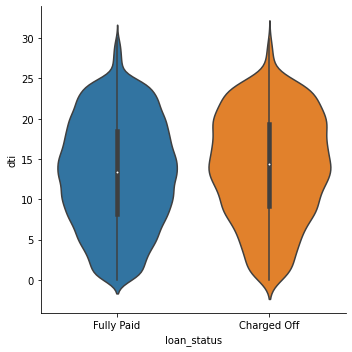

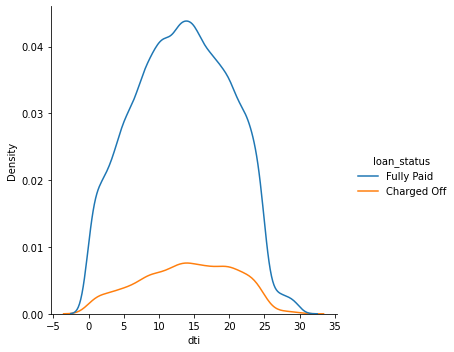

In [378]:
#Bar plots for numeric variables
for col in numeric_data:
    sns.catplot(y=col,x="loan_status",kind="violin", data=lc_df)
    sns.displot(data=lc_df, x=col, hue="loan_status", kind="kde")
    plt.show()

In [379]:
#Inferences 


In [380]:
pivot=pd.pivot_table(lc_df,values="id",index="term",columns="loan_status",aggfunc=lambda x: len(x.unique()))
pivot=round(pivot*100/pivot.sum(axis=0),1)
pivot

loan_status,Charged Off,Fully Paid
term,,
36 months,58.7,79.3
60 months,41.3,20.7


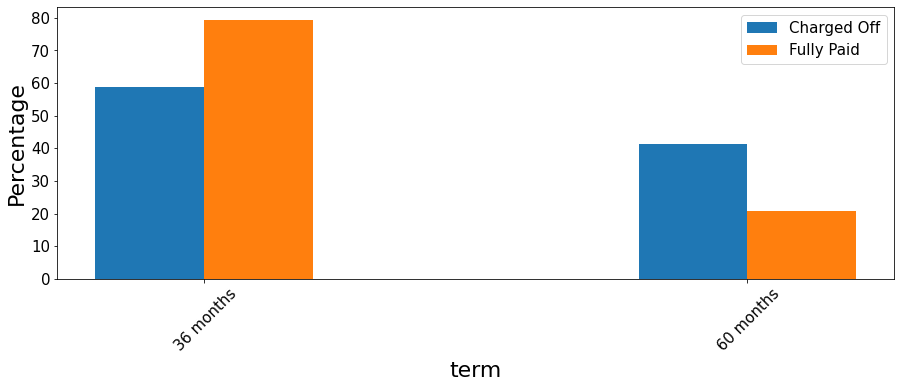

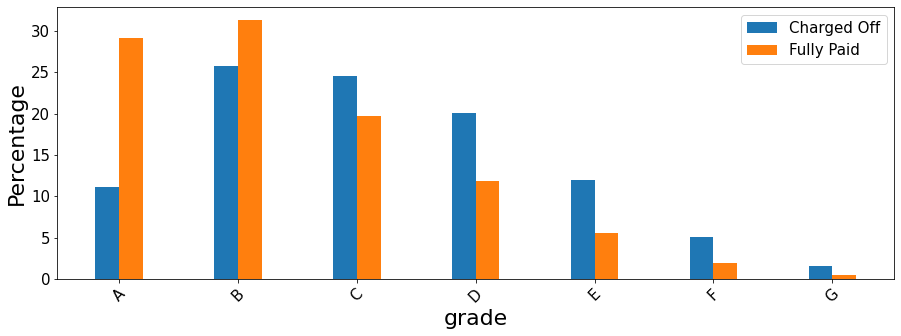

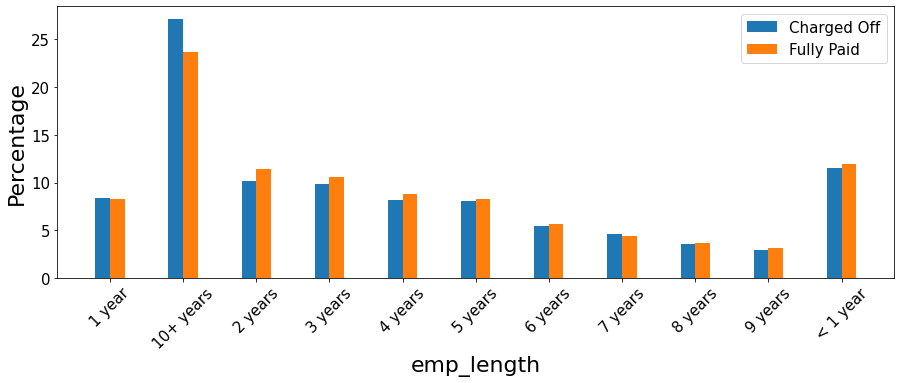

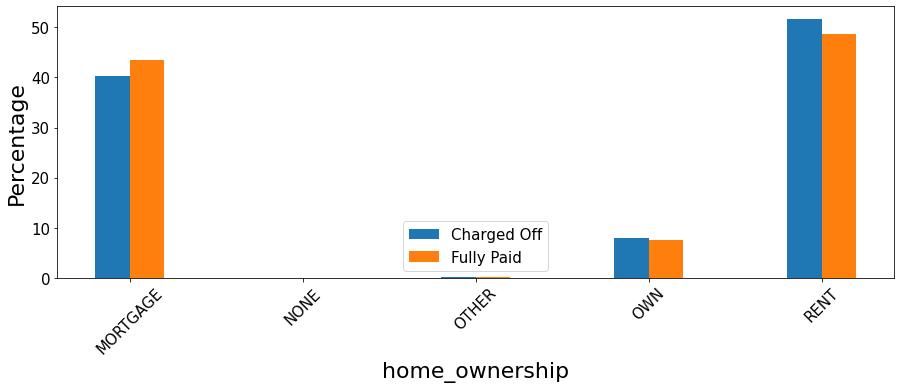

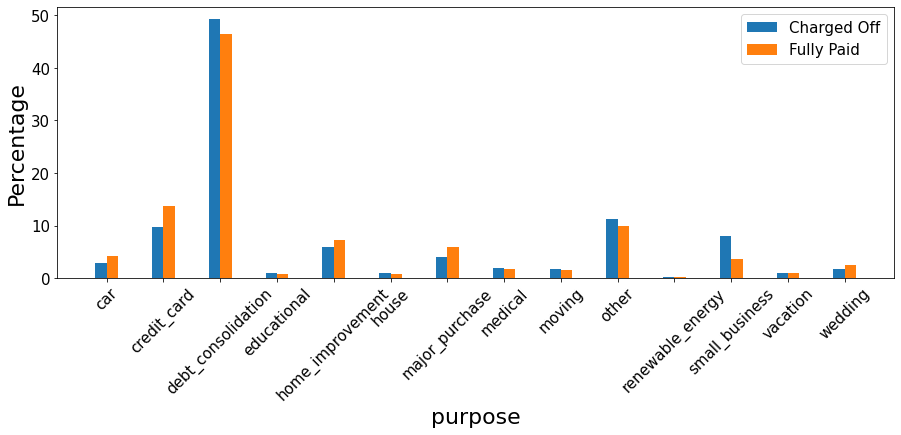

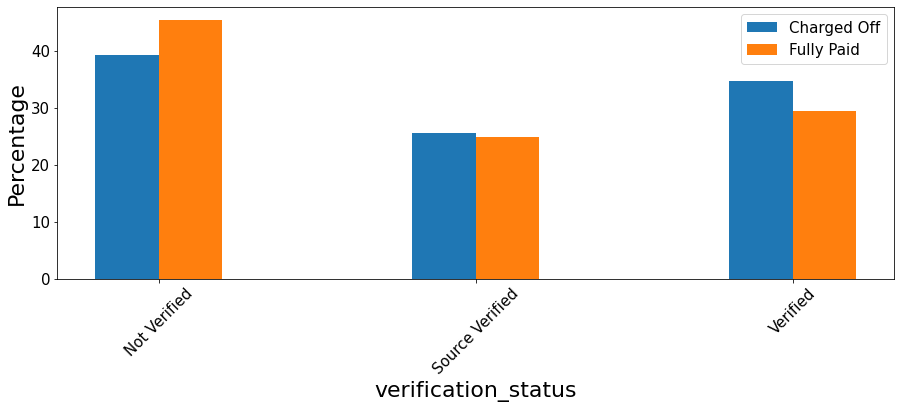

In [381]:
#Histogram for categorical Variables
def plot_bar_cat(df,index_name,column_name,width,x_lbl_rotation):
    pivot=pd.pivot_table(lc_df,values="id",index=index_name,columns=column_name,aggfunc=lambda x: len(x.unique()))
    pivot=round(pivot*100/pivot.sum(axis=0),1)
    plt.figure(figsize=(15,5))
    x_label = pivot.index
    x_data = np.arange(len(x_label)) # create values from 0 to len(x_label) - 1
    chart=[]
    for j,i in enumerate(pivot.columns):
        chart.append(plt.bar(x_data + j*(width), pivot[i],width=width,align="edge"))
    plt.xlabel(index_name,fontsize=22)
    plt.ylabel("Percentage",fontsize=22)
    x_label_pos = x_data + (len(pivot.columns)*width)/2
    plt.xticks(x_label_pos ,x_label,fontsize=15,rotation = x_lbl_rotation)
    plt.yticks(fontsize=15)
    plt.legend(chart,pivot.columns,fontsize=15)
    plt.show()

for col in cat_data:
    if col!="loan_status":
        plot_bar_cat(lc_df,col,"loan_status",0.2,45)


### **Binning numeric features**

In [382]:
# Change bin_dict variable for binning
bin_dict = {"loan_amnt":np.arange(0,31000,10000),"int_rate":np.linspace(0,25,num=6),"annual_inc":np.arange(0,151000,30000),"dti":np.linspace(0,30,num=7)}


In [383]:
#Derived Metric 1 : Employee length bins
#Employee length can be binned based on distribution into lesser categories (<1 yr,1-3yr,4-6yr,7-9yr,>10yr)
def bin_emp_len(x):
    if x in ["< 1 year"]:
        return "<1 year"
    elif x in ["1 year","2 years","3 years"]:
        return "1-3 years"
    elif x in ["4 years","5 years","6 years"]:
        return "4-6 years"
    elif x in ["7 years","8 years","9 years"]:
        return "7-9 years"
    elif x in ["10+ years"]:
        return ">10 years"
lc_df['bin_emp_length']=lc_df['emp_length'].apply(bin_emp_len)

In [384]:
# Binning numerical features
binned_cols = []
for feat,b in bin_dict.items():
    col = "bin_" + feat 
    binned_cols.append(col)
    lc_df[col] = pd.cut(lc_df[feat],bins=b,labels=label_generator(b),include_lowest=True)
#Aggregating binned columns
binned_cols.append("bin_emp_length")
print(binned_cols)

['bin_loan_amnt', 'bin_int_rate', 'bin_annual_inc', 'bin_dti', 'bin_emp_length']


In [385]:
#Viewing dataframe with binned columns
lc_df.head()

,id,loan_amnt,term,int_rate,grade,home_ownership,emp_length,annual_inc,verification_status,purpose,dti,loan_status,bin_emp_length,bin_loan_amnt,bin_int_rate,bin_annual_inc,bin_dti
0,1077501,5000,36 months,10.65,B,RENT,10+ years,24000.0,Verified,credit_card,27.65,Fully Paid,>10 years,0 to 10000,10.0 to 15.0,0 to 30000,25.0 to 30.0
1,1077430,2500,60 months,15.27,C,RENT,< 1 year,30000.0,Source Verified,car,1.00,Charged Off,<1 year,0 to 10000,15.0 to 20.0,0 to 30000,0.0 to 5.0
2,1077175,2400,36 months,15.96,C,RENT,10+ years,12252.0,Not Verified,small_business,8.72,Fully Paid,>10 years,0 to 10000,15.0 to 20.0,0 to 30000,5.0 to 10.0
3,1076863,10000,36 months,13.49,C,RENT,10+ years,49200.0,Source Verified,other,20.00,Fully Paid,>10 years,0 to 10000,10.0 to 15.0,30000 to 60000,15.0 to 20.0
5,1075269,5000,36 months,7.90,A,RENT,3 years,36000.0,Source Verified,wedding,11.20,Fully Paid,1-3 years,0 to 10000,5.0 to 10.0,30000 to 60000,10.0 to 15.0


['bin_loan_amnt', 'bin_int_rate', 'bin_annual_inc', 'bin_dti', 'bin_emp_length']


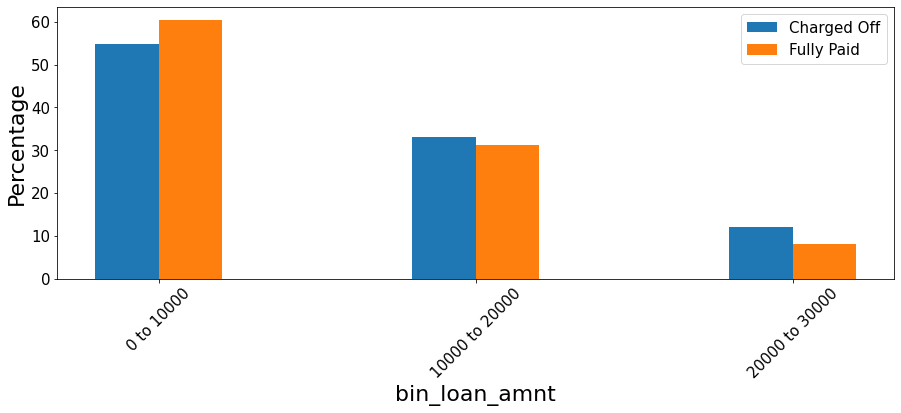

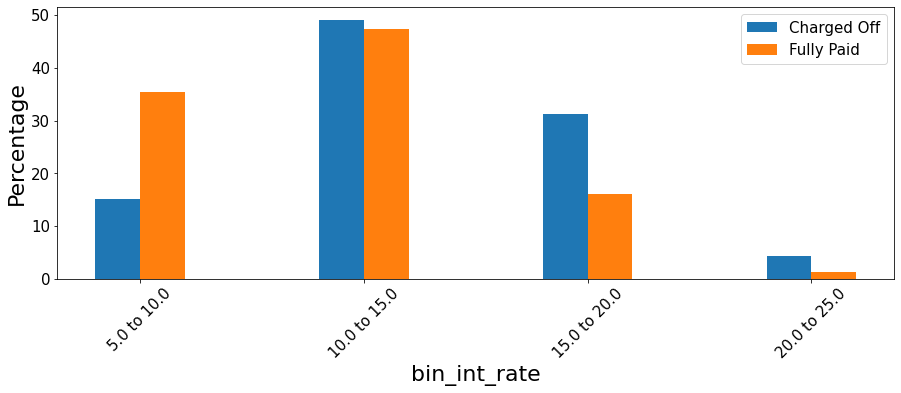

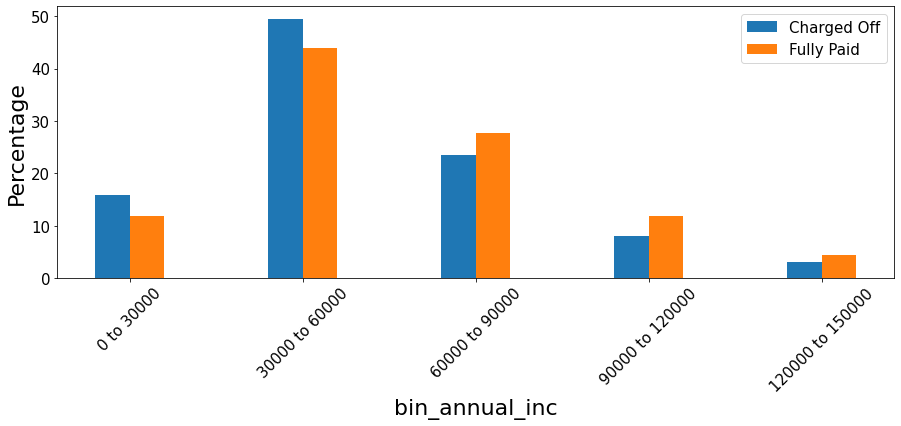

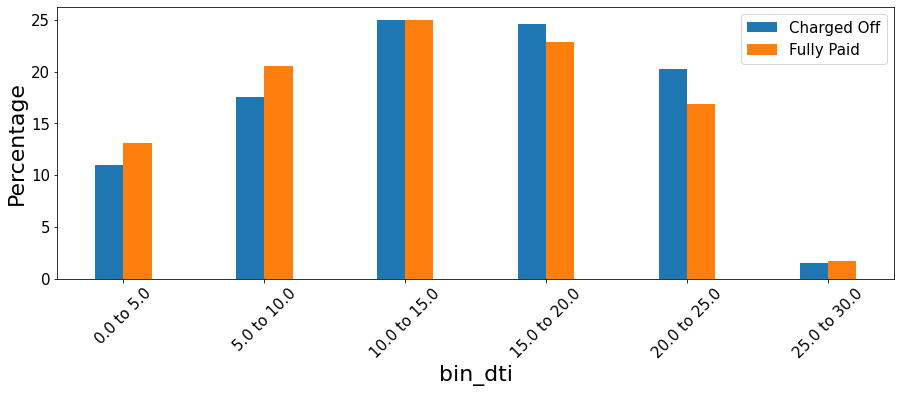

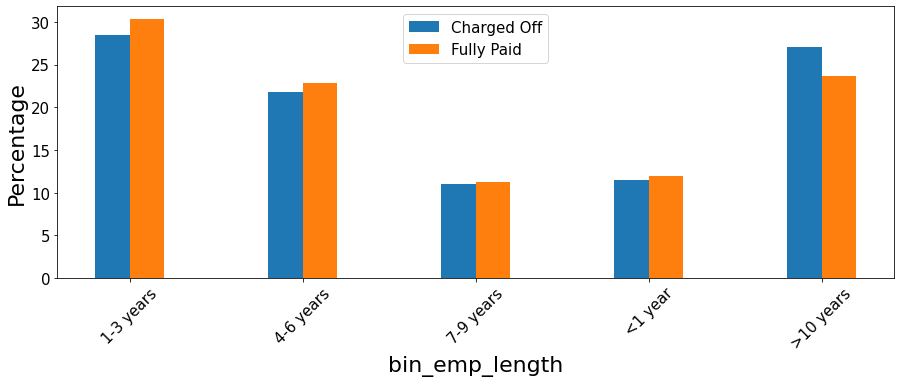

In [386]:
#Visualizing Binned columns
print(binned_cols)
for col in binned_cols:
    plot_bar_cat(lc_df,col,"loan_status",0.2,45)

### **3. Bivariate Analysis**

### Since univariate analysis is not fully indicative of the business objective to find out the driving variables for charged off customers, 
### We are visualizing the insights with respect to **fully paid** and **charged off** customers

In [387]:
# Functions for plotting bar chart for categorical variables
def plot_bar_cat(df,index_name,column_name,width,x_lbl_rotation):
    pivot=pd.pivot_table(df,values="id",index=index_name,columns=column_name,aggfunc=lambda x: len(x.unique()))
    plt.figure(figsize=(15,5))
    x_label = pivot.index
    x_data = np.arange(len(x_label)) # create values from 0 to len(x_label) - 1
    #height_data = (df[df["loan_status"]=="Fully Paid"][column_name].value_counts().values,df[df["loan_status"]=="Charged Off"][column_name].value_counts().values)
    chart=[]
    for j,i in enumerate(pivot.columns):
        chart.append(plt.bar(x_data + j*(width), pivot[i],width=width,align="edge"))
    plt.xlabel(index_name,fontsize=22)
    plt.ylabel("Frequency",fontsize=22)
    x_label_pos = x_data + (len(pivot.columns)*width)/2
    plt.xticks(x_label_pos ,x_label,fontsize=15,rotation = x_lbl_rotation)
    plt.yticks(fontsize=15)
    plt.legend(chart,pivot.columns,fontsize=15)
    plt.show()

In [388]:
def label_generator(x):
    lab = []
    for i in range(0,len(x)-1):
        lab.append(str(x[i]) + " to " + str(x[i+1]))
    return lab

### **9. Derived Metrics and Binning for Ordered Categorical Variables**

In [389]:
### **Bivariate Analysis**
#Since we are interested in analyzing the important factors for defaulters, 
#We are focussing our analysis only on charged off customers
lc_df_co=lc_df[lc_df.loan_status=="Charged Off"]

In [390]:
#Function to plot bivariate graphs
def plot_bar_cat_stack(df,index_name,column_name,width,x_lbl_rotation,title):
    ind_len=len(df[index_name].value_counts())
    col_len=len(df[column_name].value_counts())
    #Plotting more categories on x axis
    if ind_len>=col_len:
        index_pivot=index_name
        col_pivot=column_name
    else:
        index_pivot=column_name
        col_pivot=index_name      
    pivot=pd.pivot_table(df,values="id",index=index_pivot,columns=col_pivot,aggfunc=lambda x: len(x.unique()))
    pivot.plot(kind='bar', stacked=True,figsize=(15,5),use_index=True,title=title,rot=x_lbl_rotation,fontsize=12)
    plt.xlabel(pivot.index.names[0],fontsize=15)
    plt.ylabel("Frequency",fontsize=15)
    plt.show()

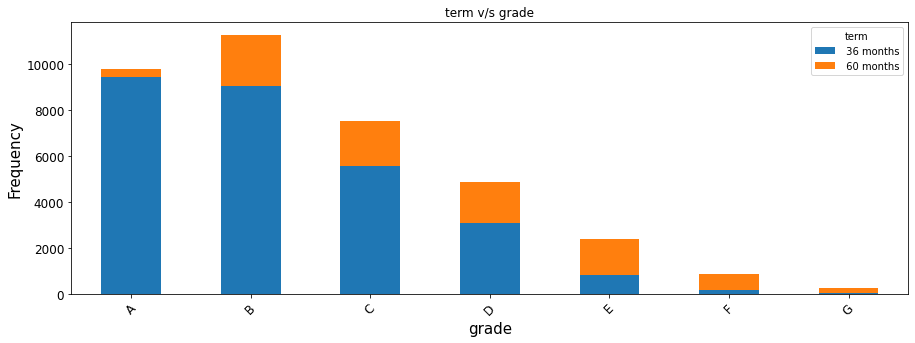

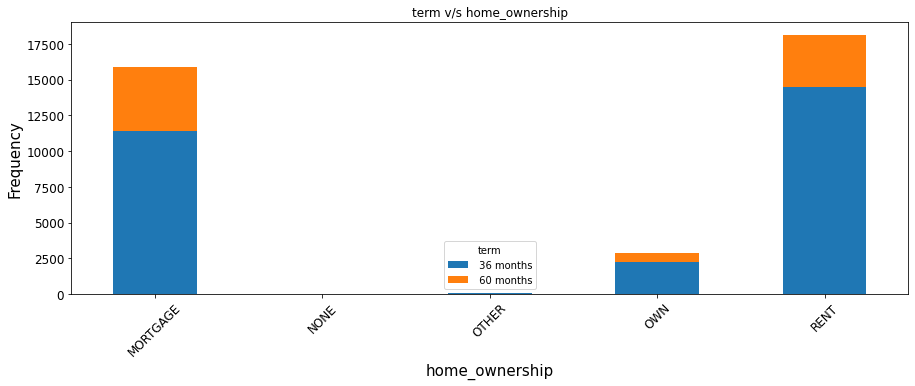

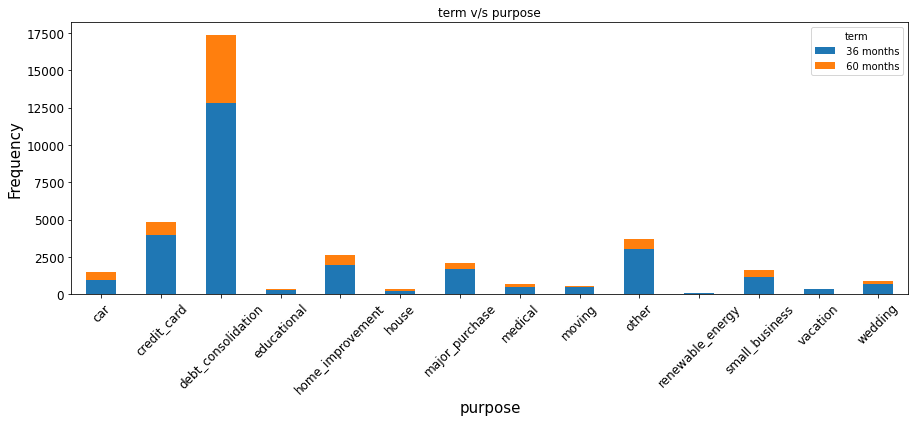

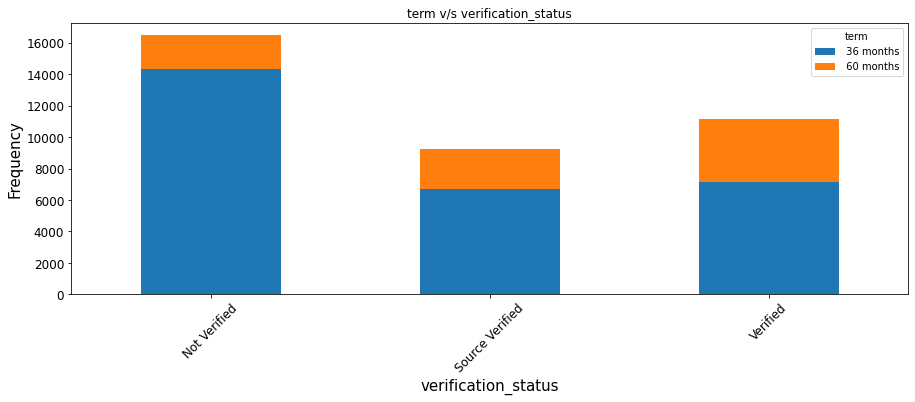

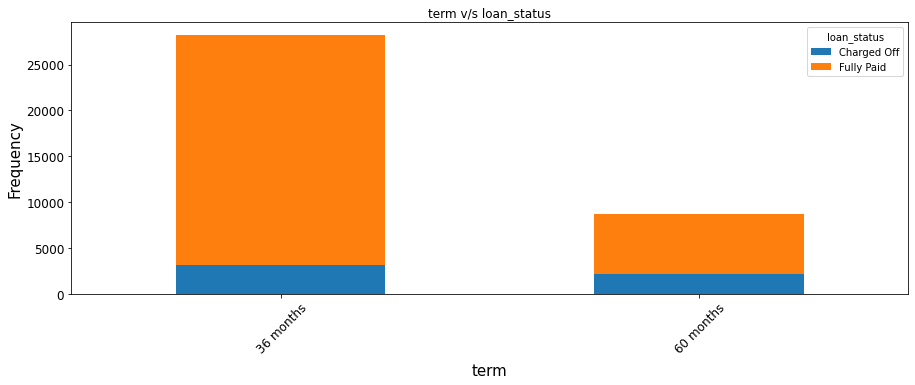

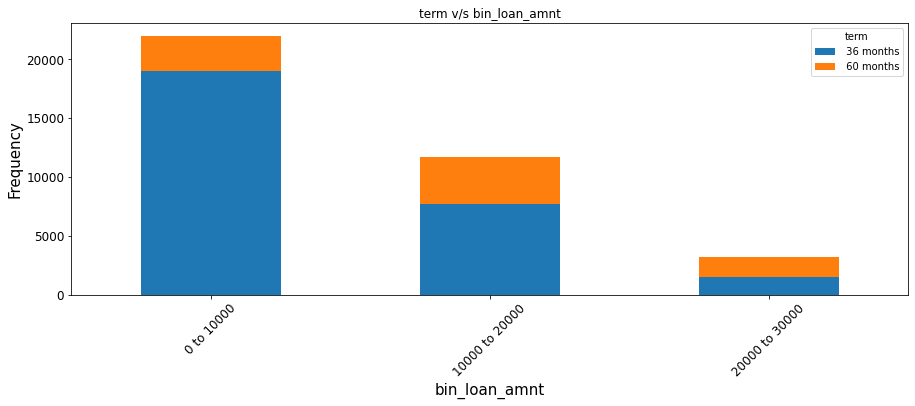

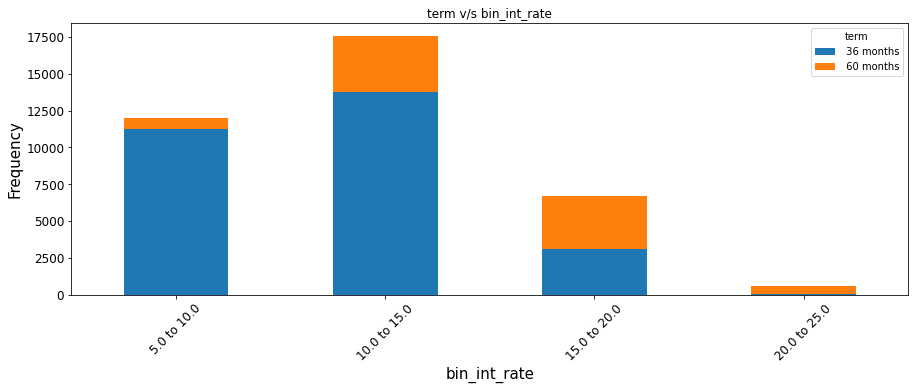

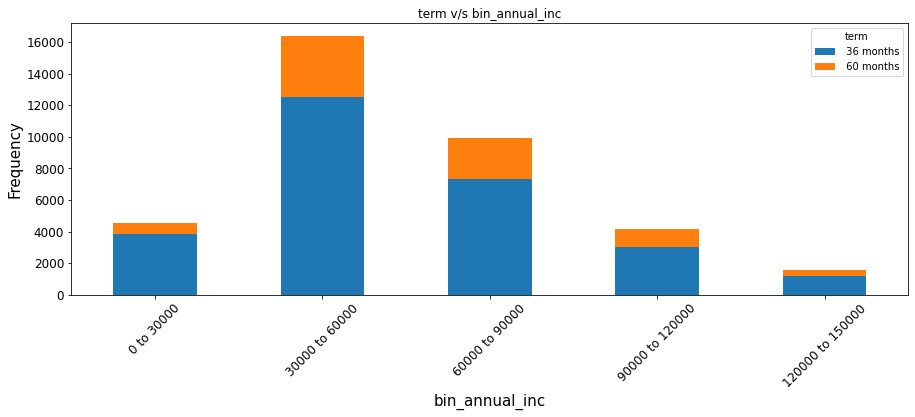

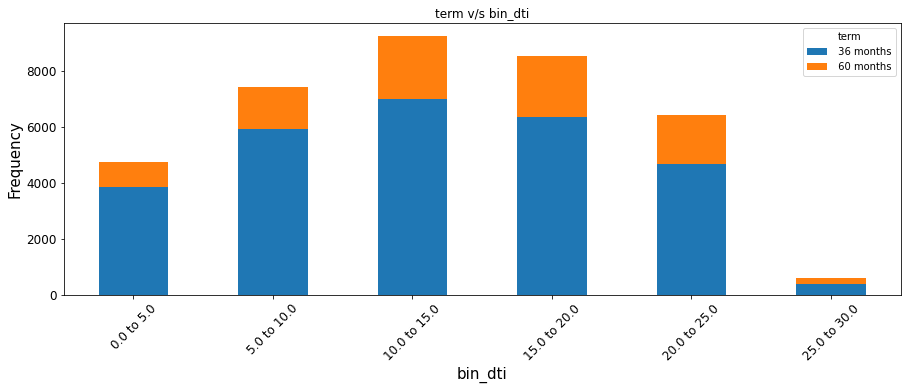

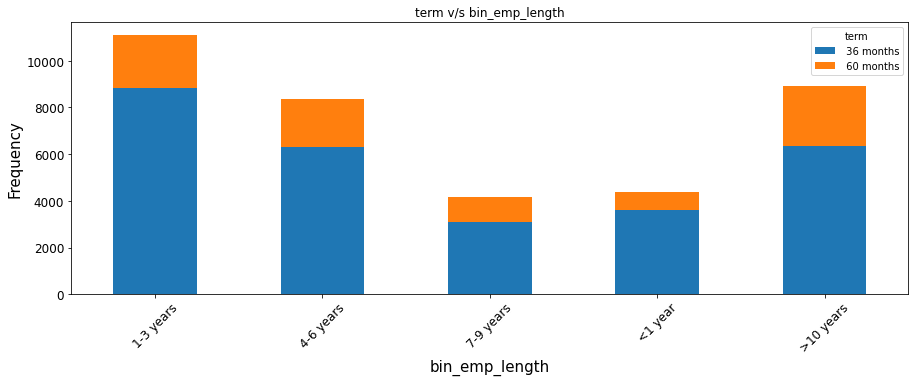

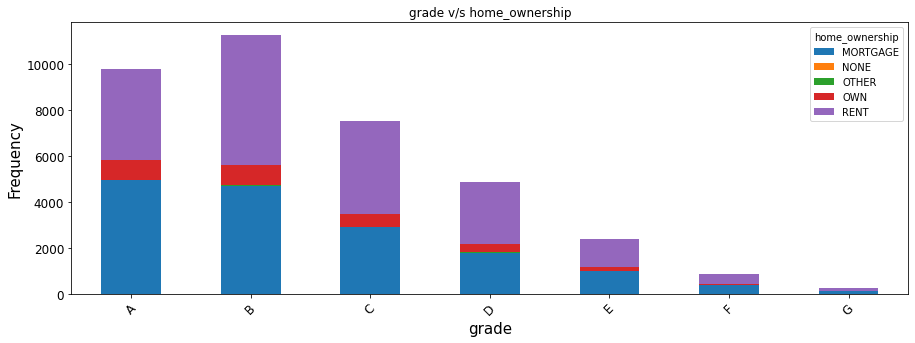

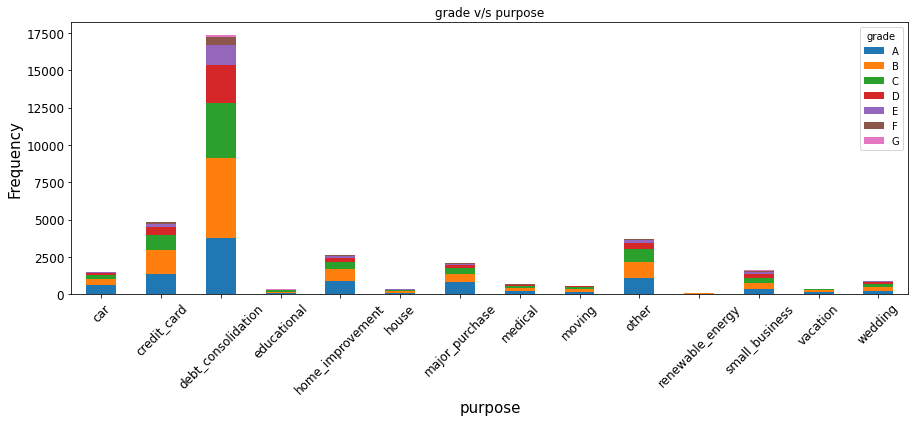

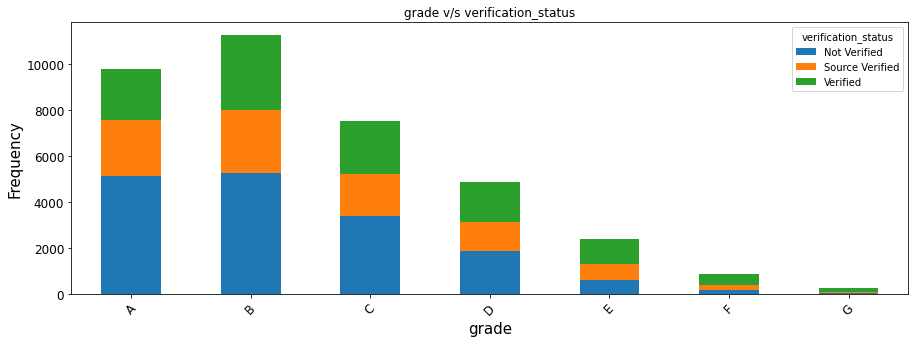

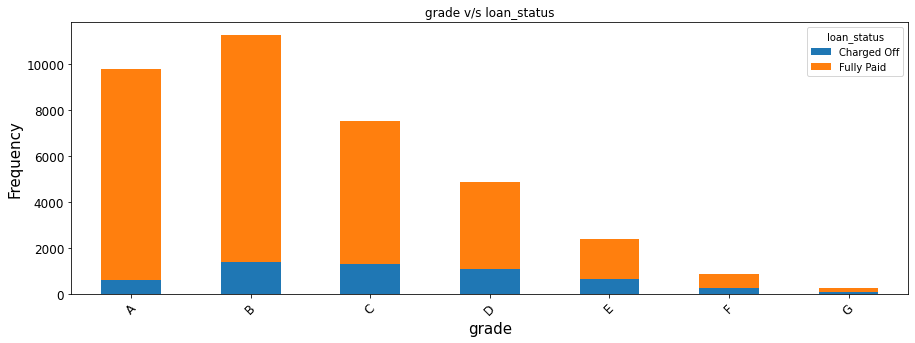

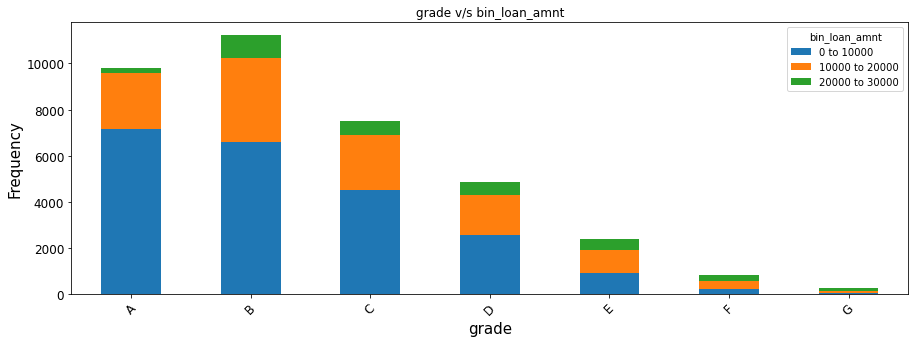

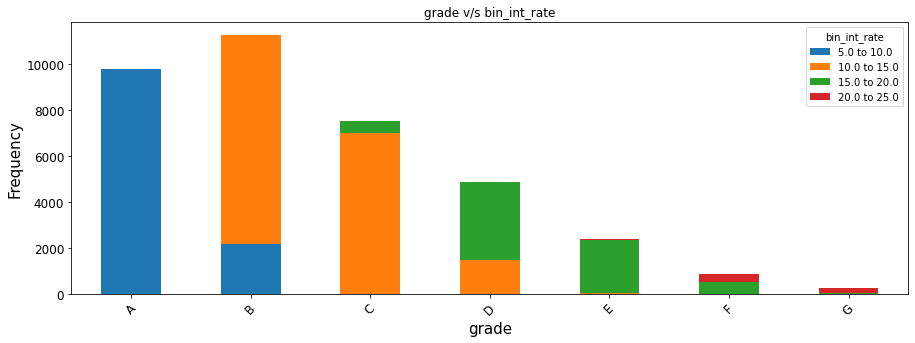

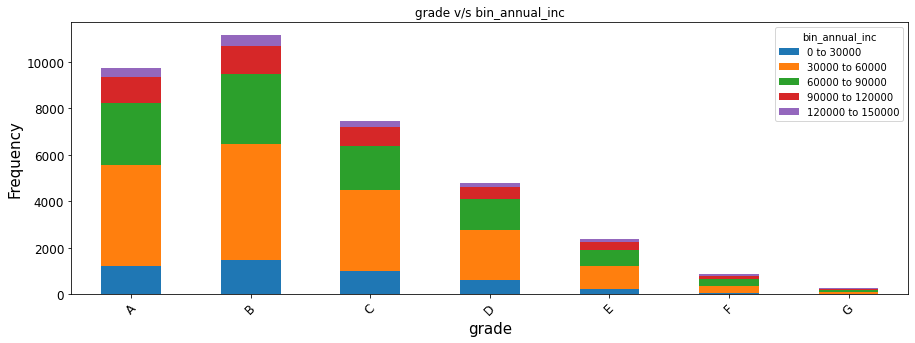

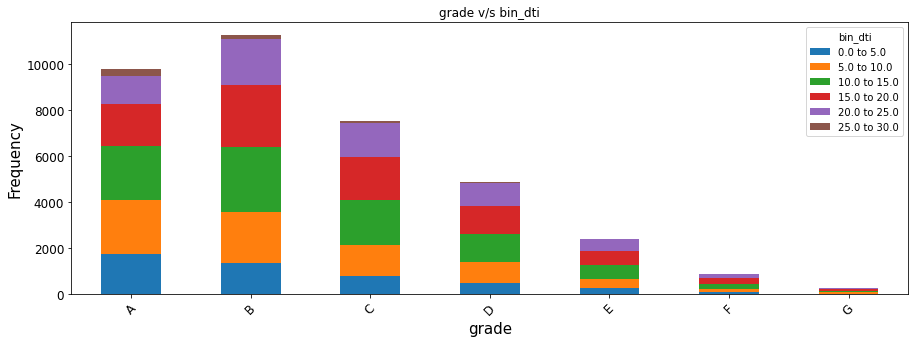

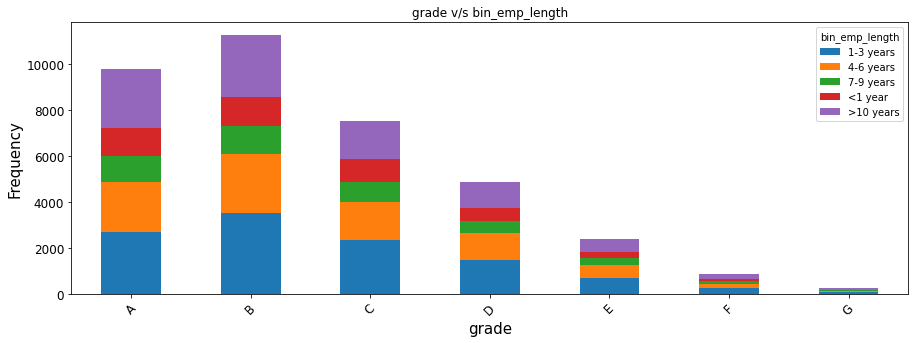

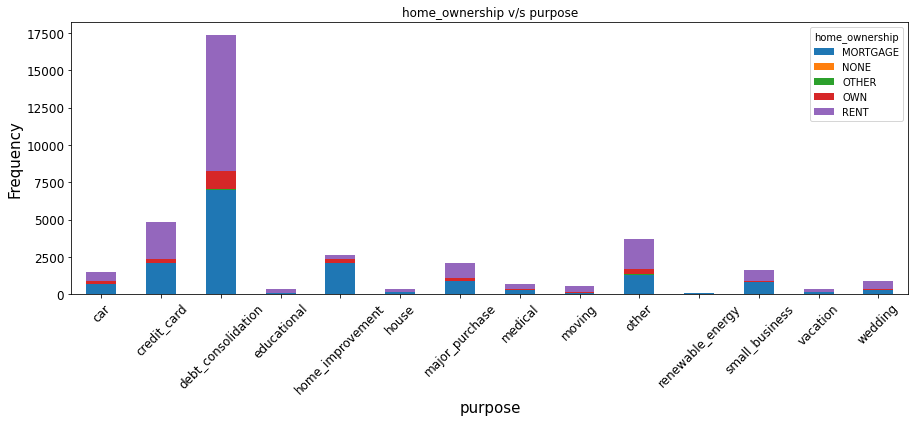

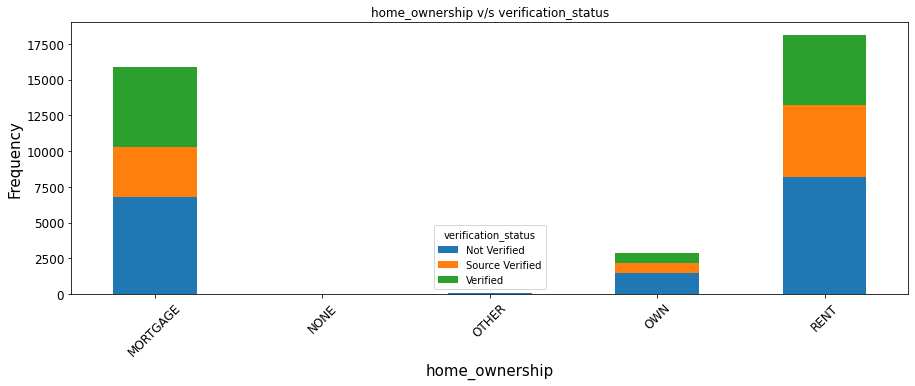

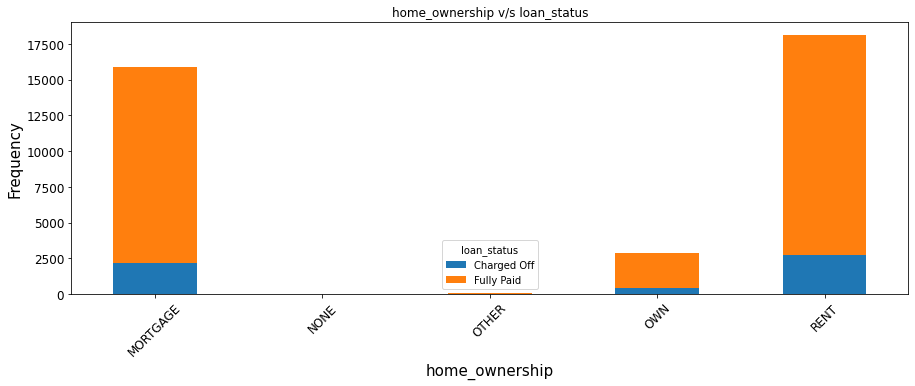

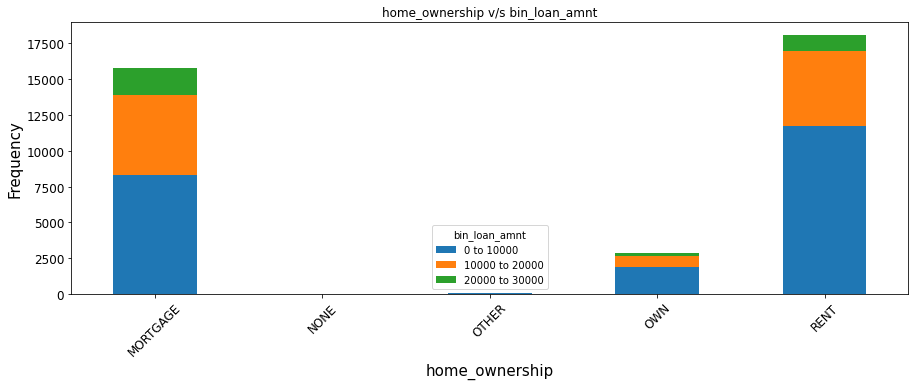

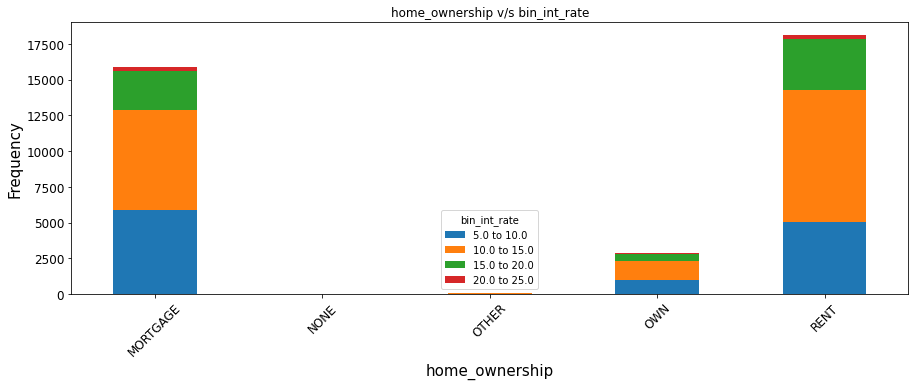

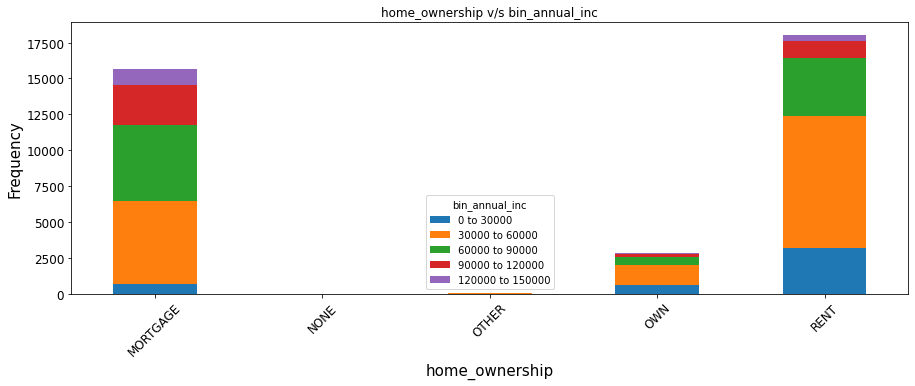

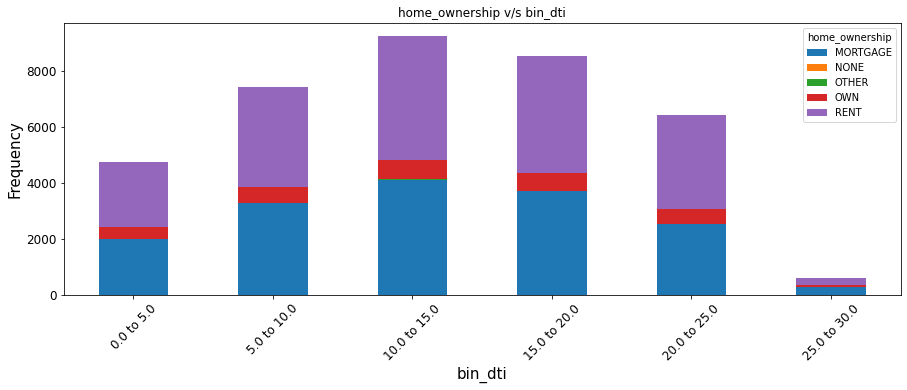

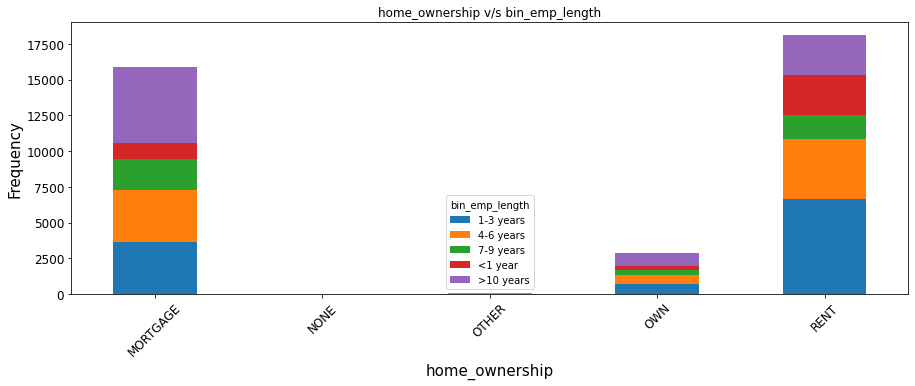

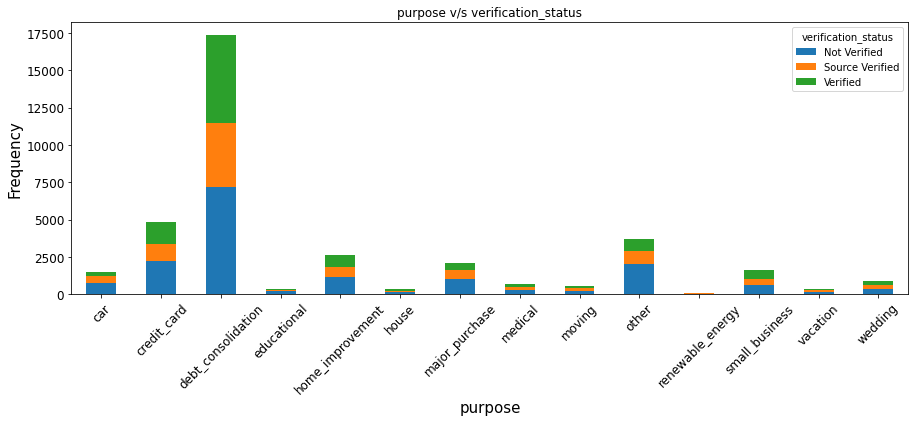

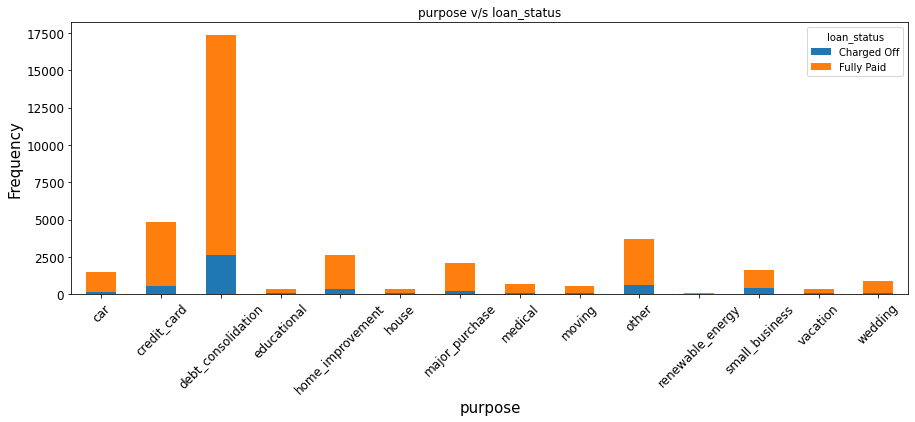

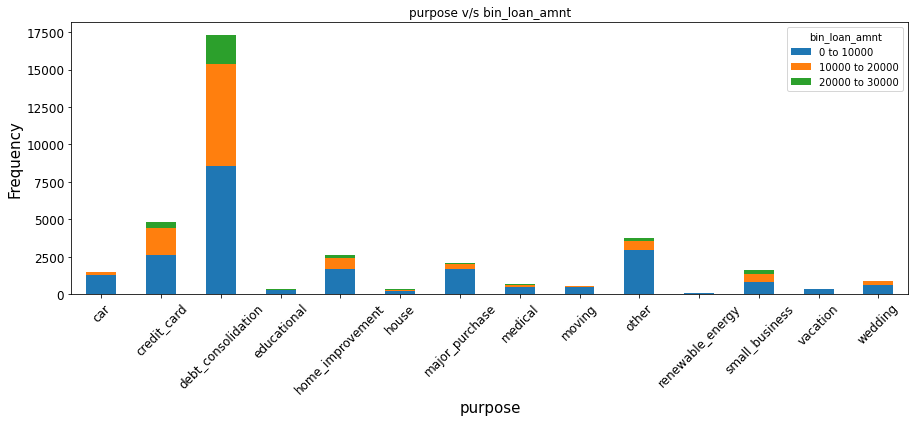

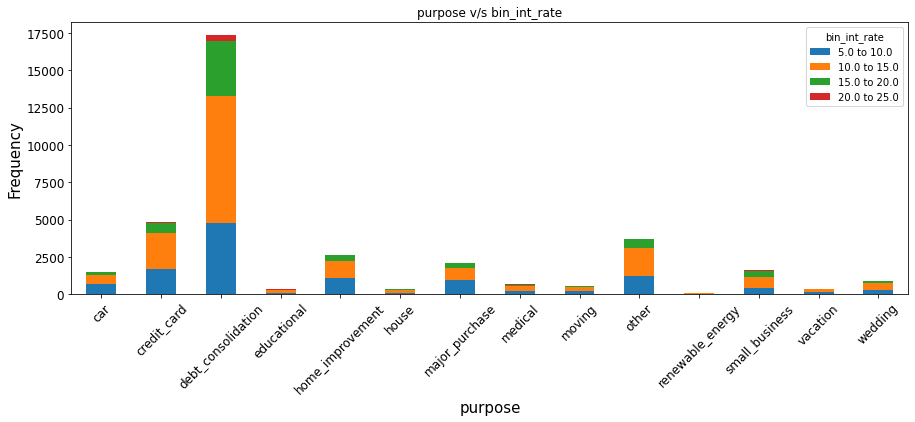

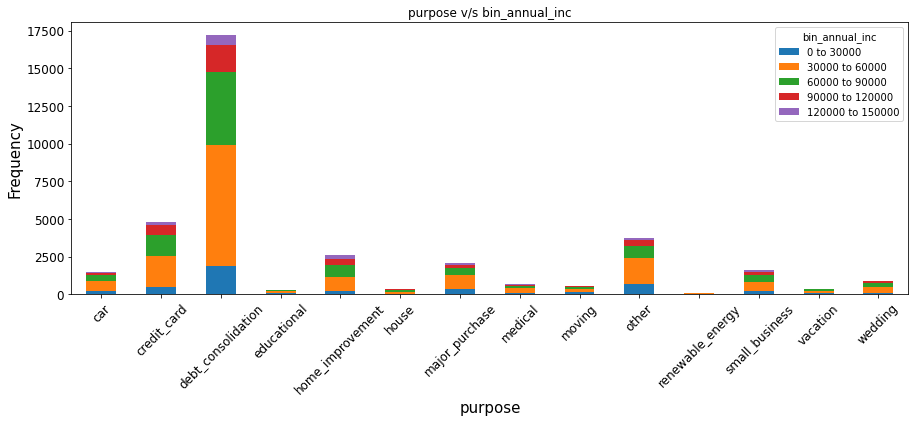

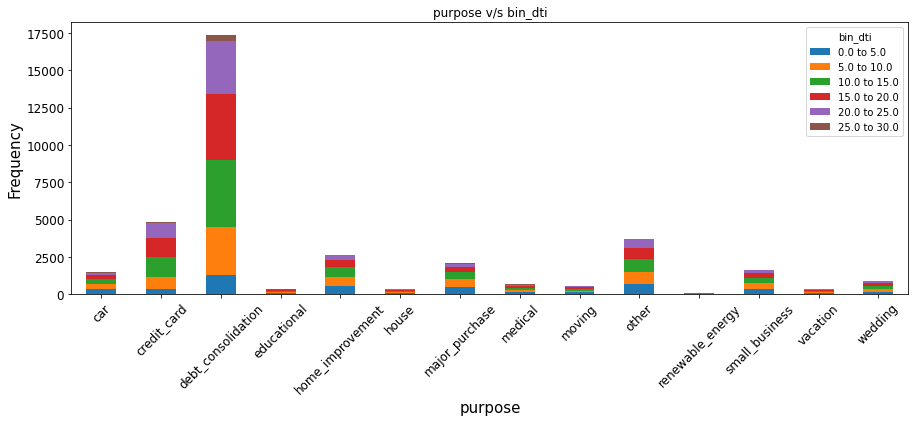

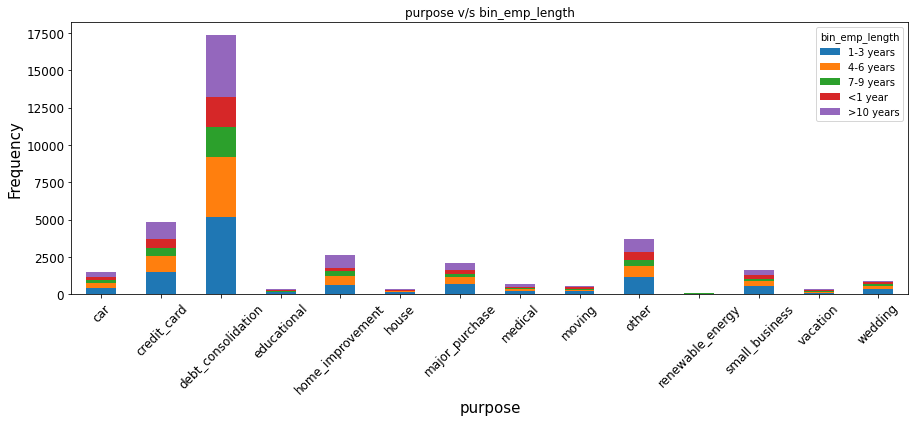

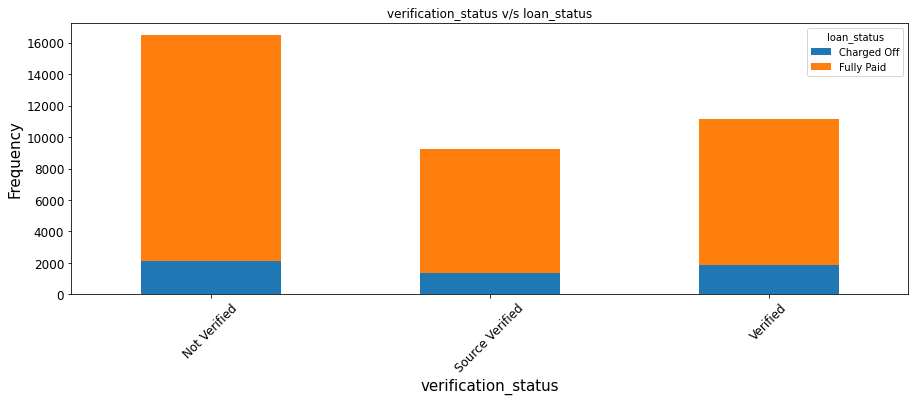

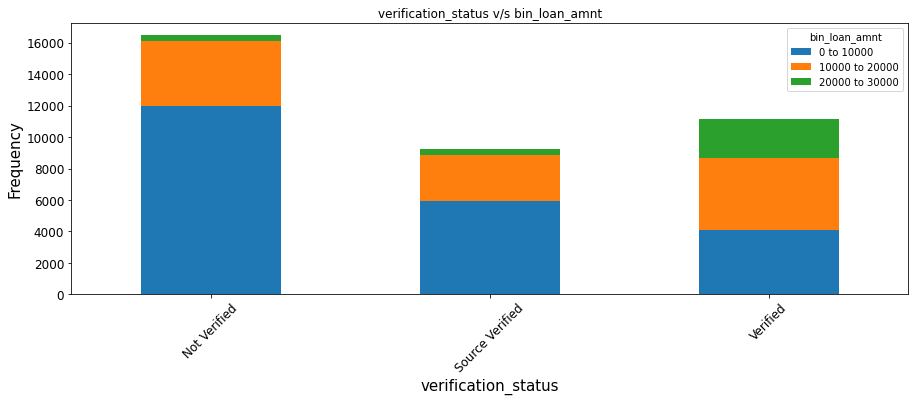

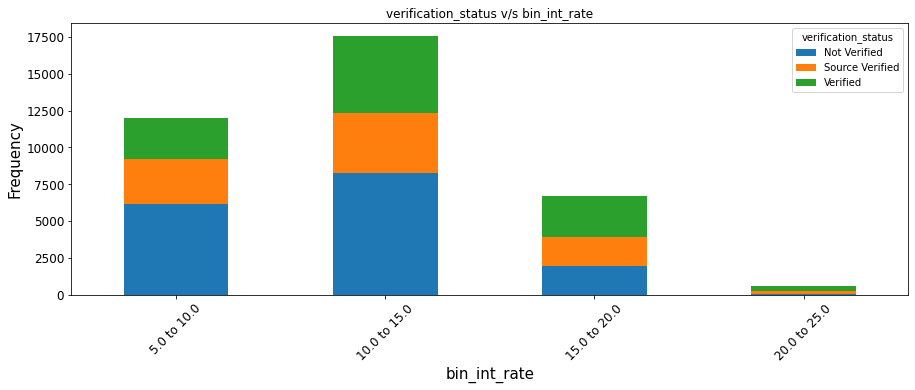

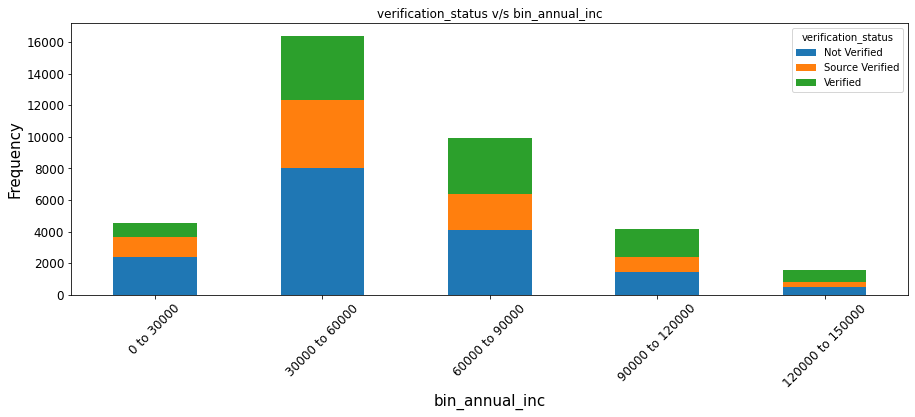

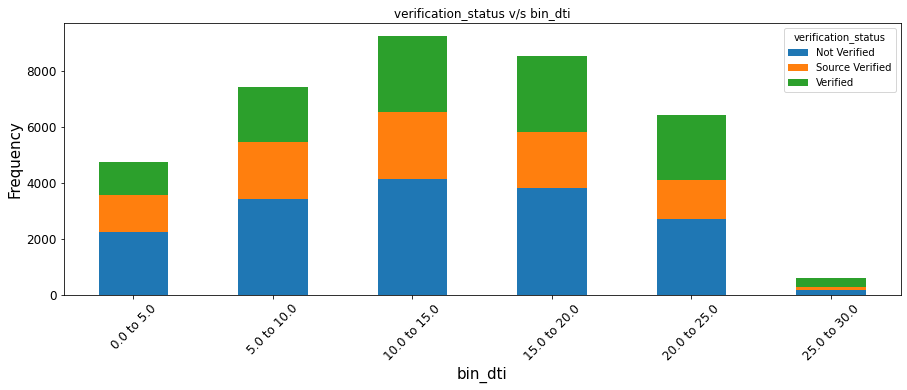

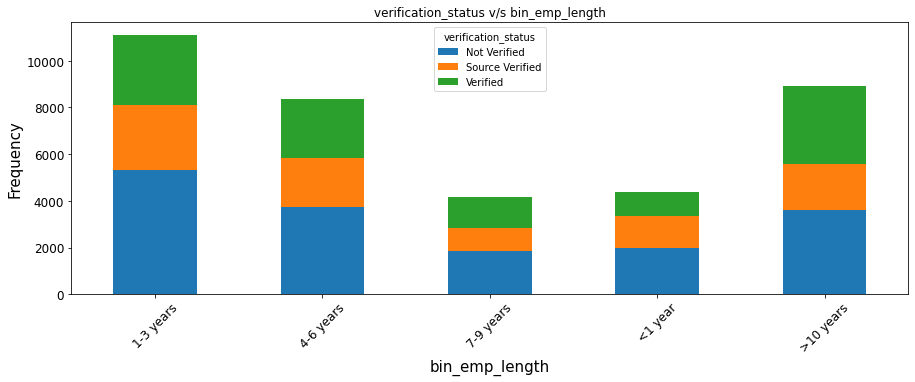

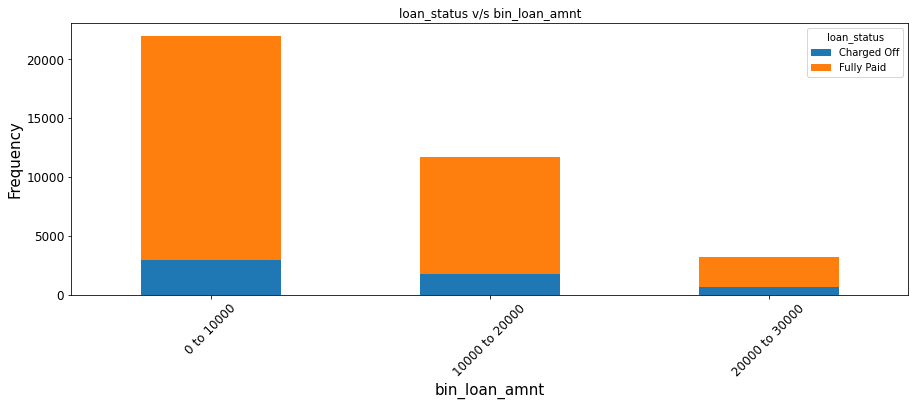

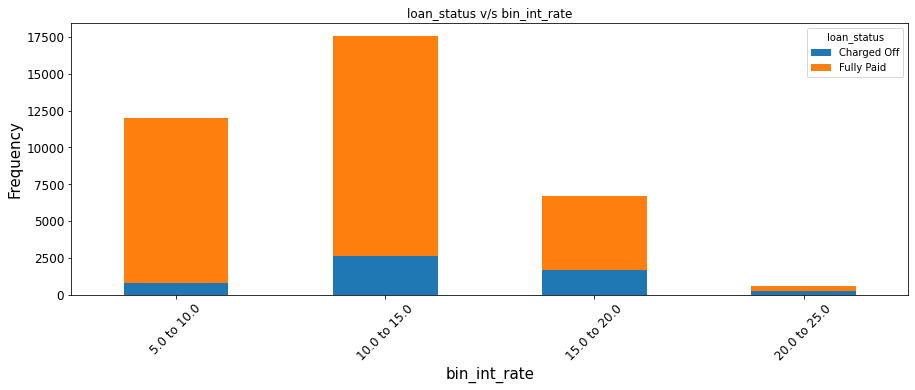

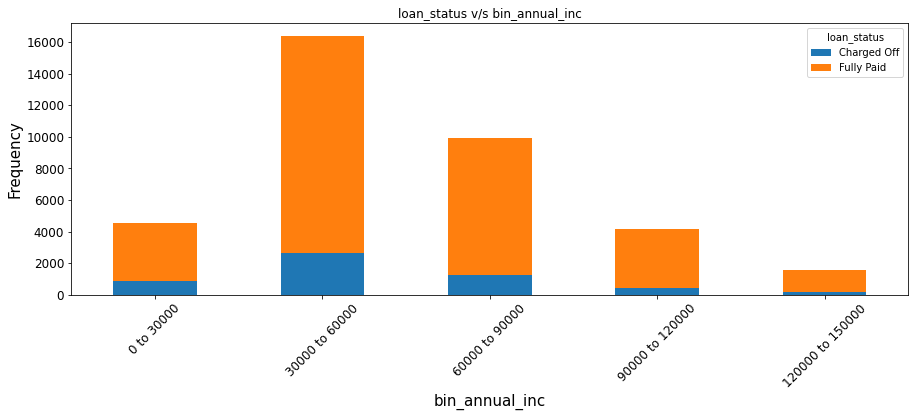

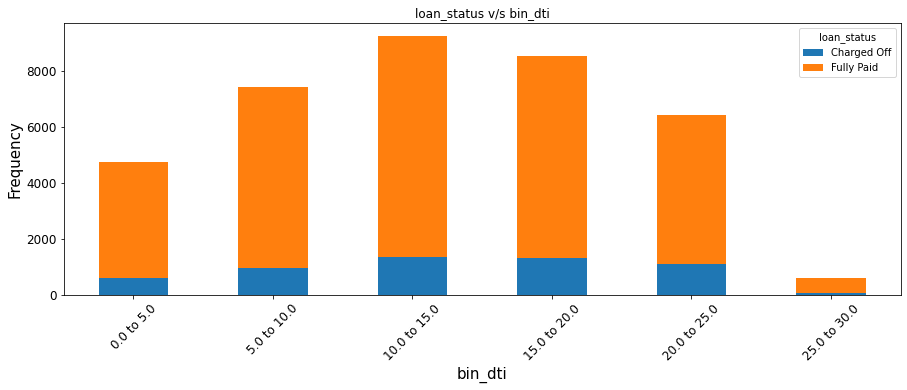

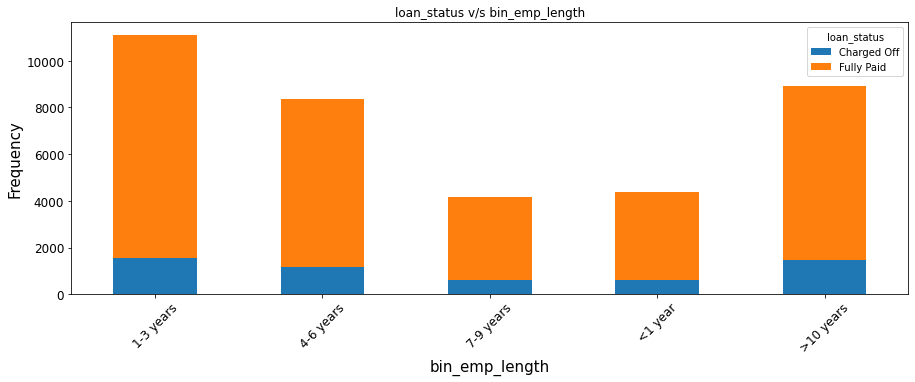

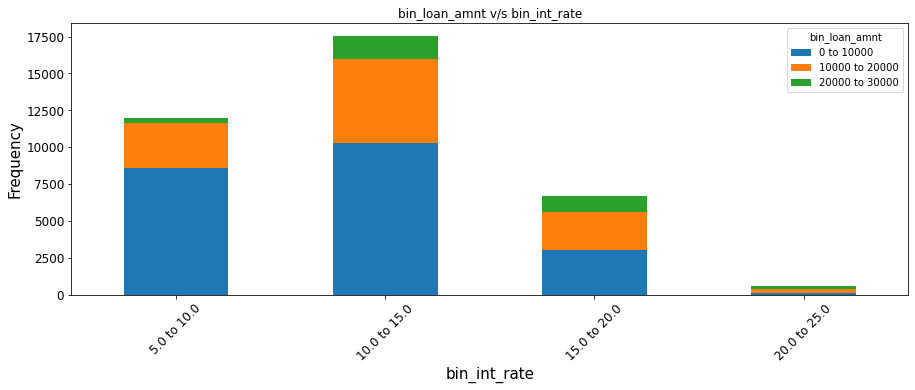

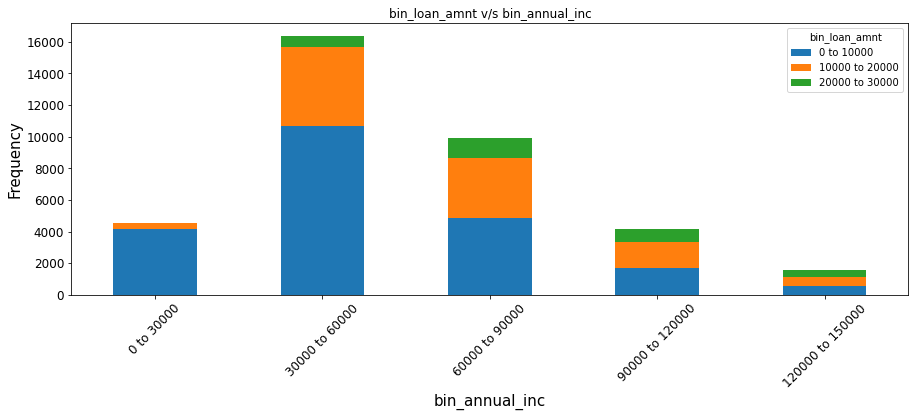

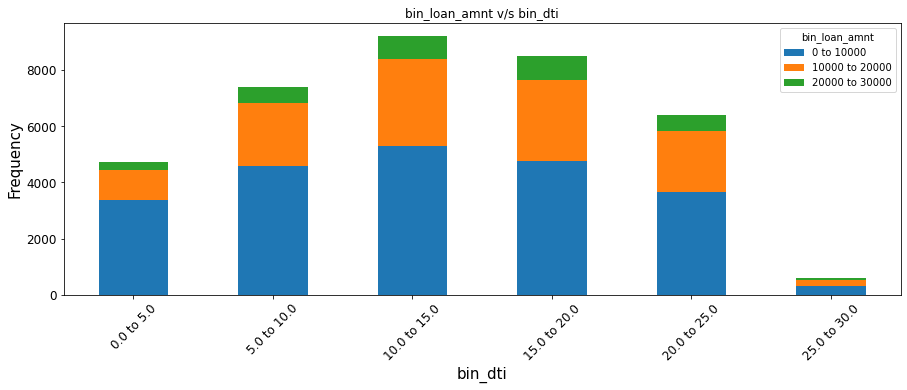

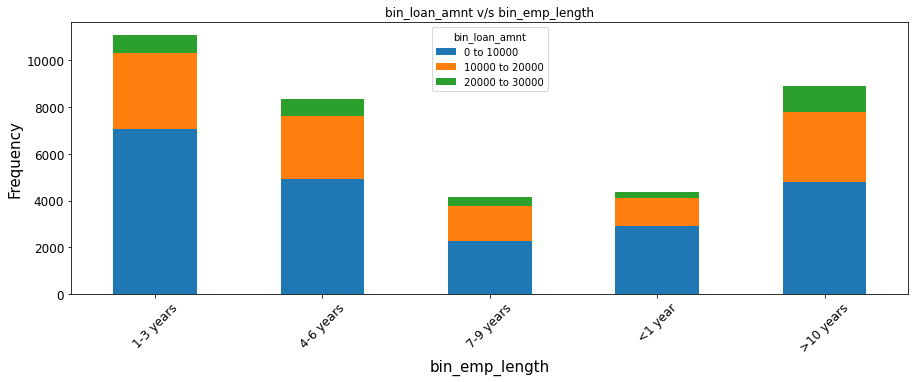

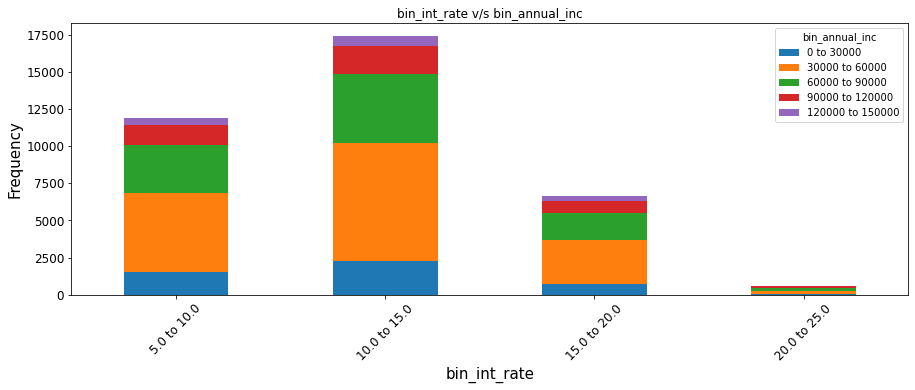

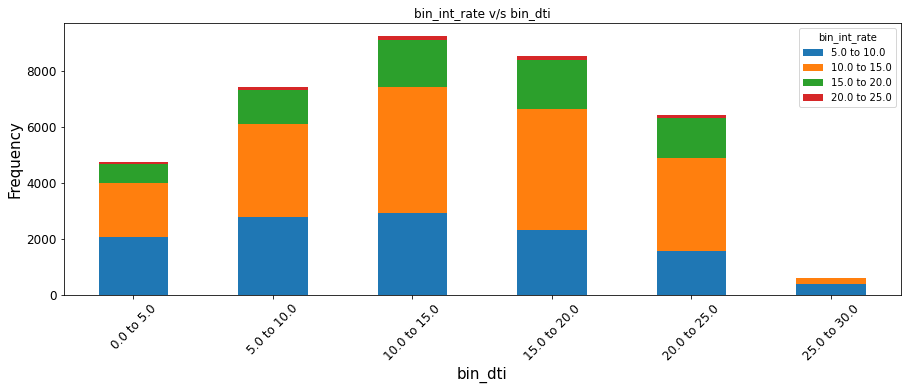

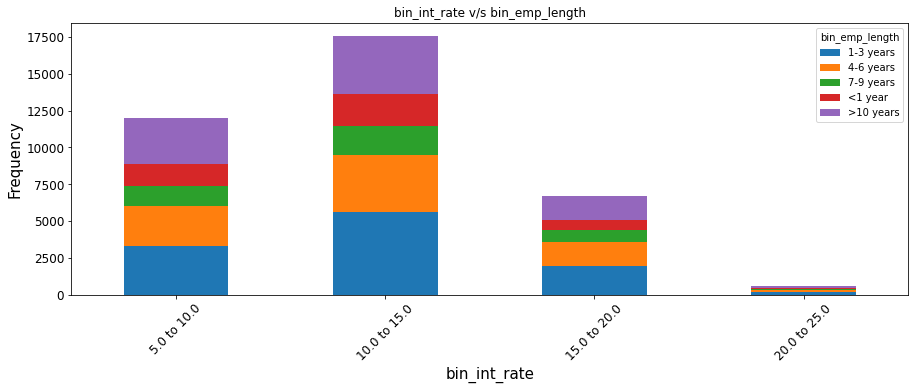

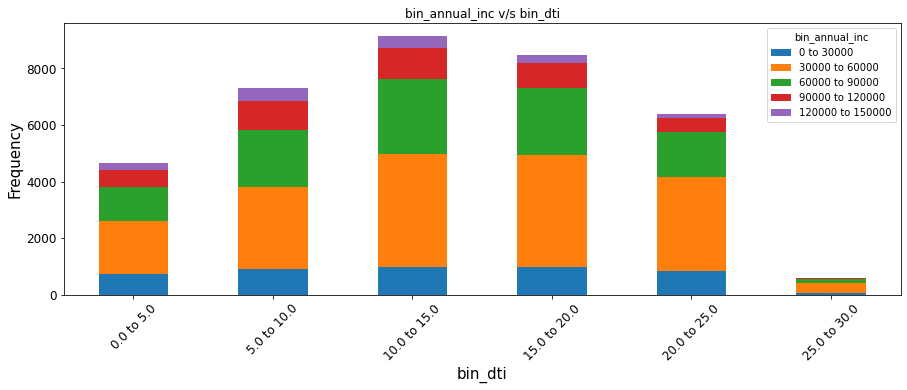

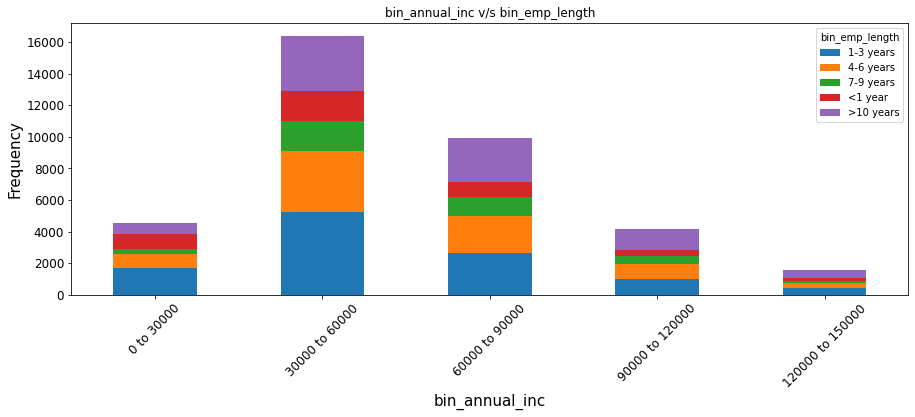

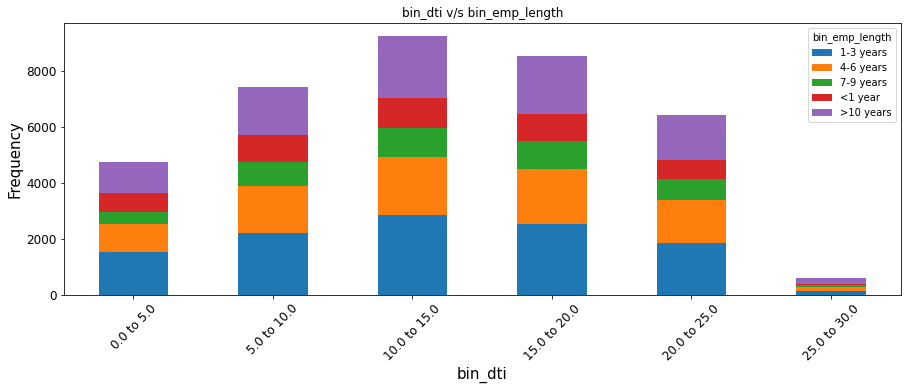

In [391]:
#Since emp length is already binned
ordered_cat_plot=ordered_cat_data.copy()
ordered_cat_plot.remove("emp_length")
#Plotting all column combinations for bivariate
cat_plot_cols=ordered_cat_plot+unordered_cat_data+binned_cols
comm_list=[]
#Find out unique combinations of columns to view for bivariate analysis
for c1 in cat_plot_cols:
    for c2 in cat_plot_cols:
        if c1!=c2:
            tup=(c1,c2)
            rev_tup=(c2,c1)
            if not rev_tup in comm_list:
                comm_list.append(tup)
        
for c1,c2 in comm_list:
#     # plot_bar_cat(lc_df,c1,c2,0.1,45)
    plot_bar_cat_stack(lc_df,c1,c2,0.1,45,f"{c1} v/s {c2}")


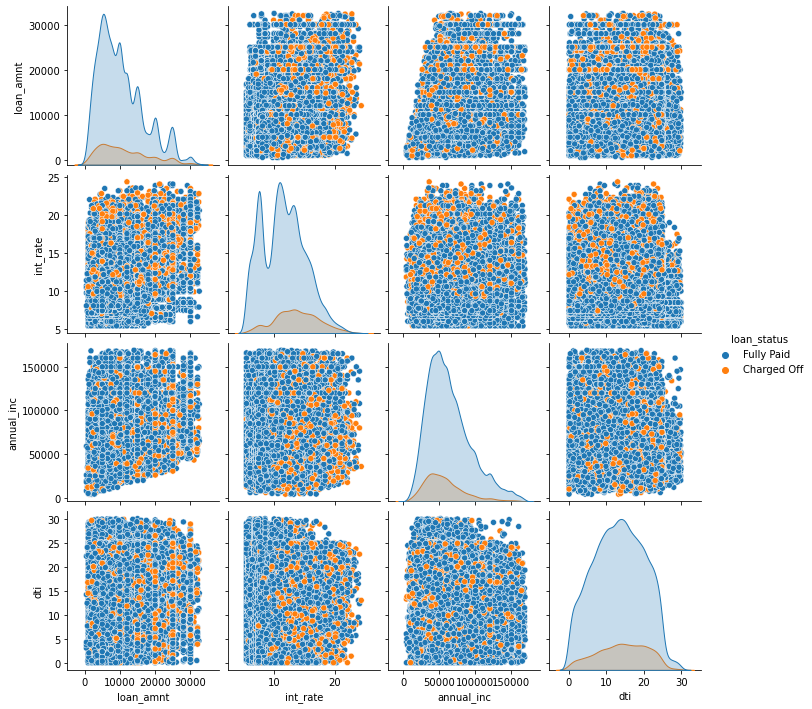

In [392]:
#Pair Plots
pair_plot_cols=numeric_data.copy()
pair_plot_cols.append('loan_status')
sns.pairplot(lc_df[pair_plot_cols], hue ='loan_status')
plt.show()

### **Inferences from bivariate analysis**

In [393]:
# 
#

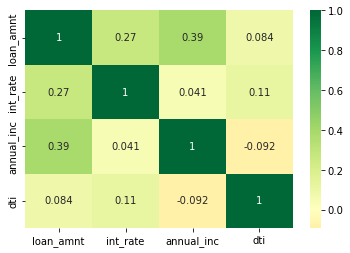

In [406]:
#Numeric Features correlation
ax = sns.heatmap(lc_df[numeric_data].corr(),center=0, annot=True,cmap="RdYlGn")

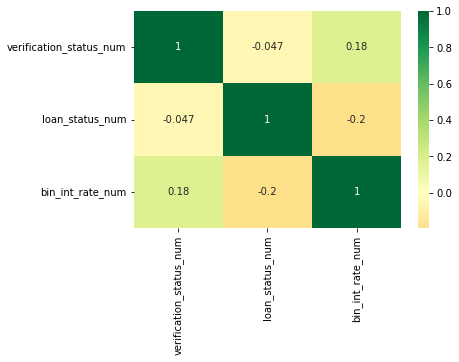

In [408]:
#Categorical Features
lc_df['loan_status_num']=lc_df['loan_status'].replace("Charged Off","0").replace("Fully Paid","1").astype('int')
lc_df['verification_status_num']=lc_df['verification_status'].replace("Not Verified","0").replace("Source Verified","1").replace("Verified","2").astype('int')
lc_df['bin_int_rate_num']=lc_df['bin_int_rate'].replace("0.0 to 5.0","0").replace("5.0 to 10.0","1").replace("10.0 to 15.0","2").replace("15.0 to 20.0","3").replace("20.0 to 25.0","4").astype('int')
# lc_df.head()
lc_df_corr=lc_df[["verification_status_num","loan_status_num","bin_int_rate_num"]]
corr_matrix=lc_df_corr.corr()
ax = sns.heatmap(corr_matrix,center=0, annot=True,cmap="RdYlGn")

### **Analysis on More than Two Variables**

In [236]:
lc_df

,id,loan_amnt,term,int_rate,grade,sub_grade,home_ownership,emp_length,annual_inc,verification_status,purpose,addr_state,dti,open_acc,total_acc,delinq_2yrs,earliest_cr_line,bin_emp_length,closed_acc,bin_closed_acc,ear_cre_li_year,bin_ear_cre_li_year,bin_loan_amnt,bin_int_rate,bin_annual_inc,bin_dti,bin_open_acc
1,1077430,2500,60 months,15.27,C,C4,RENT,< 1 year,30000.0,Source Verified,car,GA,1.00,3,4,0,Apr-99,<1 year,1,0 to 15,1999,1995 to 2005,0 to 10000,15.0 to 20.0,0 to 30000,0.0 to 5.0,0 to 10
8,1071795,5600,60 months,21.28,F,F2,OWN,4 years,40000.0,Source Verified,small_business,CA,5.55,11,13,0,Apr-04,4-6 years,2,0 to 15,2004,1995 to 2005,0 to 10000,20.0 to 25.0,30000 to 60000,5.0 to 10.0,10 to 20
9,1071570,5375,60 months,12.69,B,B5,RENT,< 1 year,15000.0,Verified,other,TX,18.08,2,3,0,Sep-04,<1 year,1,0 to 15,2004,1995 to 2005,0 to 10000,10.0 to 15.0,0 to 30000,15.0 to 20.0,0 to 10
12,1064687,9000,36 months,13.49,C,C1,RENT,< 1 year,30000.0,Source Verified,debt_consolidation,VA,10.08,4,9,0,Apr-04,<1 year,5,0 to 15,2004,1995 to 2005,0 to 10000,10.0 to 15.0,0 to 30000,10.0 to 15.0,0 to 10
14,1069057,10000,36 months,10.65,B,B2,RENT,3 years,100000.0,Source Verified,other,CA,7.06,14,29,0,May-91,1-3 years,15,0 to 15,1991,1985 to 1995,0 to 10000,10.0 to 15.0,90000 to 120000,5.0 to 10.0,10 to 20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39666,119043,15450,36 months,11.22,C,C4,MORTGAGE,2 years,40000.0,Not Verified,debt_consolidation,VA,13.50,13,29,0,Nov-92,1-3 years,16,15 to 30,1992,1985 to 1995,10000 to 20000,10.0 to 15.0,30000 to 60000,10.0 to 15.0,10 to 20
39667,118823,2500,36 months,12.80,D,D4,MORTGAGE,< 1 year,32000.0,Not Verified,home_improvement,NE,20.00,11,32,0,Jul-92,<1 year,21,15 to 30,1992,1985 to 1995,0 to 10000,10.0 to 15.0,30000 to 60000,15.0 to 20.0,10 to 20
39668,118533,2500,36 months,9.64,B,B4,MORTGAGE,< 1 year,75000.0,Not Verified,home_improvement,NE,20.00,9,35,0,Feb-94,<1 year,26,15 to 30,1994,1985 to 1995,0 to 10000,5.0 to 10.0,60000 to 90000,15.0 to 20.0,0 to 10
39678,113179,1000,36 months,10.59,C,C2,MORTGAGE,2 years,33990.0,Not Verified,wedding,VA,14.47,9,11,0,Jul-04,1-3 years,2,0 to 15,2004,1995 to 2005,0 to 10000,10.0 to 15.0,30000 to 60000,10.0 to 15.0,0 to 10


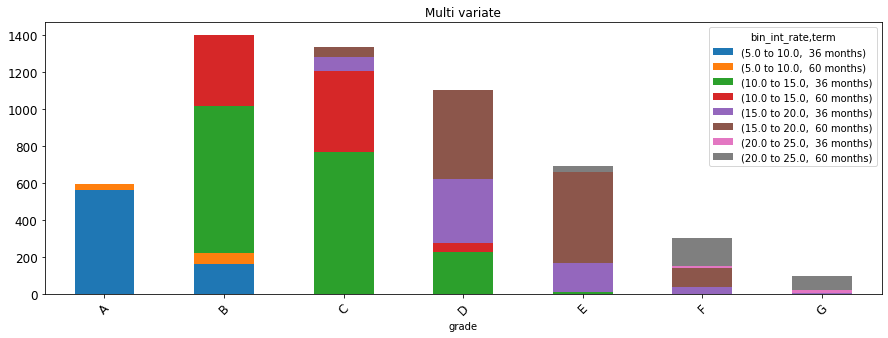

In [228]:
pivot=pd.pivot_table(lc_df,values="id",index="grade",columns=("bin_int_rate","term"),aggfunc=lambda x: len(x.unique()))
pivot.plot(kind='bar', stacked=True,figsize=(15,5),use_index=True,title="Multi variate",rot=45,fontsize=12)
plt.show()


In [234]:
# Employees having employee length 7-9 years and having 30 to 40 open accounts have higher chances of charging off
# For moving and renewable energy,the probabilty of charged off customers is higher for people taking loan amount from 20000 to 30000
# Employee with >10 years of experience takig loan for small business tend to chargeoff more 